In [1]:
import numpy as np                                                             #Must normalize spectra (i.e. find median value across each spectrum, and then divide each spectrum by this value.)
from astropy.io import fits
import matplotlib.pyplot as py
import os
import myAstroMods as mm
import importlib as imp
import os, os.path
from astropy.stats import sigma_clip
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from matplotlib.path import Path
imp.reload(mm)
%matplotlib inline



In [2]:
hdu = fits.open('/Users/Jonhays/Documents/ASTRO/FITS/SPLASH/subMasterSPLASH.fits')
hdu2 = fits.open('/Users/Jonhays/Documents/ASTRO/FITS/SPLASH/carbonSPLASHdata/nonCarbonSPLASH.fits')
hdu3 = fits.open('/Users/Jonhays/Documents/ASTRO/FITS/SPLASH/carbonSPLASHdata/marginalCarbonSPLASH.fits')
hdu4 = fits.open('/Users/Jonhays/Documents/ASTRO/FITS/SPLASH/carbonSPLASHdata/weakCarbonSPLASH.fits')
hdu5 = fits.open('/Users/Jonhays/Documents/ASTRO/FITS/SPLASH/carbonSPLASHdata/carbonSPLASH.fits')
wNmIndices = np.load('wNmIndices.npy')
wClusterInd = np.load('Wstar_clusters.npy')
marClusterInd = np.load('Mstar_clusters.npy')
ncClusterInd = np.load('noncarbon_star_clusters.npy')



In [6]:
# Take note! This cell proves that the submaster SPLASH field 'FULLNAME' is unique for every star! good to know...

# for i in range(len(data)):
#     isUnique = data['FULLNAME'][i] == data['FULLNAME']
#     nUnique = isUnique[isUnique == 1]
#     if len(nUnique) != 1:
#         print('ERRRORRRR!')
#         break
# ~np.any(data['FULLNAME'][22091] == clusterData['FULLNAME'])

In [7]:
data = hdu[1].data           # All data
ncData = hdu2[1].data        # non-cargon data
marData = hdu3[1].data       # marginal carbon data
wcData = hdu4[1].data        # weak carbon data
weakCNdata = data[wNmIndices]  # Weak and marginal data
scienceData = hdu5[1].data
CdataIndices = [i for i in range(len(data)) if np.any(data['FULLNAME'][i] == scienceData['FULLNAME']) and ~np.any(i == wNmIndices)]
Cdata = data[CdataIndices]
len(Cdata)





98

In [11]:
diskData = [data[i] for i in range(len(data)) if data['MASK'][i][0:3] == 'mct']
CdiskData = [Cdata[i] for i in range(len(Cdata)) if Cdata['MASK'][i][0:3] == 'mct']

In [12]:
# Locating error index

# for i in wNmIndices:
#     if np.any(data['FULLNAME'][i] == Cdata['FULLNAME']):
#         print('error sc')
#         print(i)
#     if np.any(data['FULLNAME'][i] == mcData['FULLNAME']):
#         print('error mc')
#         print(i)
#     if np.any(data['FULLNAME'][i] == exData['FULLNAME']):
#         print('error ex')
#         print(i)
    
# errorIndex = 20867

In [13]:
# errorSpec = data['SPEC'][errorIndex]
# wv = data['LBIN'][0]
# py.rcParams['figure.figsize'] = 20, 8

# py.plot(wv, errorSpec)

In [14]:
print(len(diskData))
print(len(Cdata))
len(CdiskData)
data.columns

10386
98


ColDefs(
    name = 'LBIN'; format = '9230E'
    name = 'SPEC'; format = '9230E'
    name = 'IVAR'; format = '9230E'
    name = 'MASK'; format = '7A'
    name = 'SLITNAME'; format = '3A'
    name = 'OBJNAME'; format = '16A'
    name = 'FULLNAME'; format = '38A'
    name = 'ZSNR'; format = 'D'
    name = 'GRATE'; format = 'D'
    name = 'FLAG'; format = 'D'
    name = 'ZQUAL'; format = 'D'
    name = 'RA'; format = '11A'
    name = 'DEC'; format = '11A'
    name = 'POS_A'; format = 'D'
    name = 'SSNR'; format = 'D'
    name = 'MASKRA'; format = 'A'
    name = 'MASKDEC'; format = 'A'
    name = 'PAR_A'; format = 'D'
    name = 'AIRMASS'; format = 'D'
    name = 'ABAND'; format = 'D'
    name = 'MJD'; format = 'D'
    name = 'Z'; format = 'D'
    name = 'SPECNORMED'; format = '9230E'
    name = 'IVARNORMED'; format = '9230E'
    name = 'FIELDTYPE'; format = '9A'
    name = 'CID'; format = '3A'
    name = 'CN'; format = 'D'
    name = 'TIO'; format = 'D'
    name = 'F275W'; format = 'D'


In [15]:
clusterIndices = []
clusterIndices.extend(wClusterInd)
clusterIndices.extend(marClusterInd)
clusterIndices.extend(ncClusterInd)
clusterData = data[clusterIndices]

In [16]:
fluxnorm = []
ivarnorm = []
for i in range(len(weakCNdata)):
    [fluxtemp, ivartemp ] = mm.normal(weakCNdata['SPEC'][i], weakCNdata['IVAR'][i])
    fluxnorm += [fluxtemp]
    ivarnorm += [ivartemp]
fluxnorm = np.array(fluxnorm)
ivarnorm = np.array(ivarnorm)


/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [17]:
wv = weakCNdata['LBIN'][0]

In [18]:
# Coaddition of weak AND marginal carbon stars using Katie's weighted ave. method
coaddspec, coaddivar, clipspec, clipivar = mm.sigclip_coadd_arr(weakCNdata['LBIN'], fluxnorm, ivarnorm, verbose = True)
clipspec5, clipivar5 = mm.sigclip_coadd_arr(weakCNdata['LBIN'], fluxnorm, ivarnorm, sigLim = 5)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:208: RuntimeWarning: invalid value encountered in multiply
  coaddspec = np.nansum(spec*ivar, axis = 0)/coaddivar
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:221: RuntimeWarning: invalid value encountered in less
  subspec.append(np.nansum(s[nsig < sigLim]*iv[nsig < sigLim]))
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:222: RuntimeWarning: invalid value encountered in less
  clipivar.append(np.nansum(iv[nsig < sigLim]))
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:220: RuntimeWarning: invalid value encountered in multiply
  nsig = np.abs((s - coaddspec[j])*np.sqrt(iv))
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:220: RuntimeWarning: invalid value encountered in subtract
  nsig = np.abs((s - coaddspec[j])*np.sqrt(iv))
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:224: RuntimeWarning: invalid value encountered in true_divide
  clipspec

In [19]:
# Coaddition of weak/marginal carbon stars using Elisa's median method
wNmCoadd3med = mm.coadd_med(fluxnorm, ivarnorm, wv)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:282: RuntimeWarning: invalid value encountered in multiply
  sigdiff=abs(fluxnorm-medflux)*np.sqrt(ivarnorm)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:284: RuntimeWarning: invalid value encountered in greater
  clip[sigdiff>siglim]=0
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:286: RuntimeWarning: invalid value encountered in multiply
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:286: RuntimeWarning: invalid value encountered in true_divide
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:287: RuntimeWarning: divide by zero encountered in true_divide
  coadderr=1/np.sqrt(np.nansum(ivarnorm*clip,0))


In [20]:
# Defining smoothing kernels (currently not in unused)
gauss = Gaussian1DKernel(1)
box = Box1DKernel(13)
smoothSpec = convolve(clipspec5, gauss)

(0, 1.6)

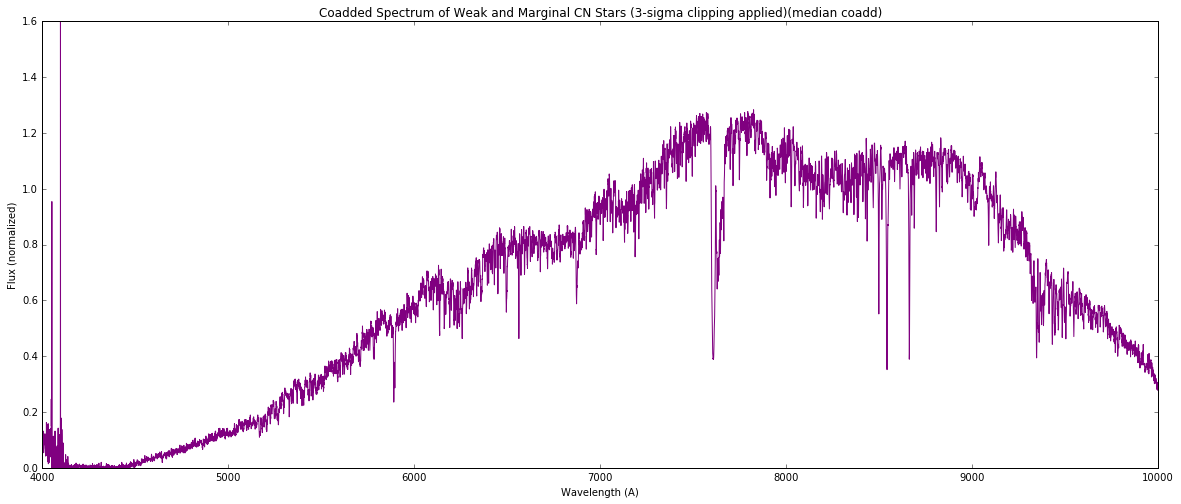

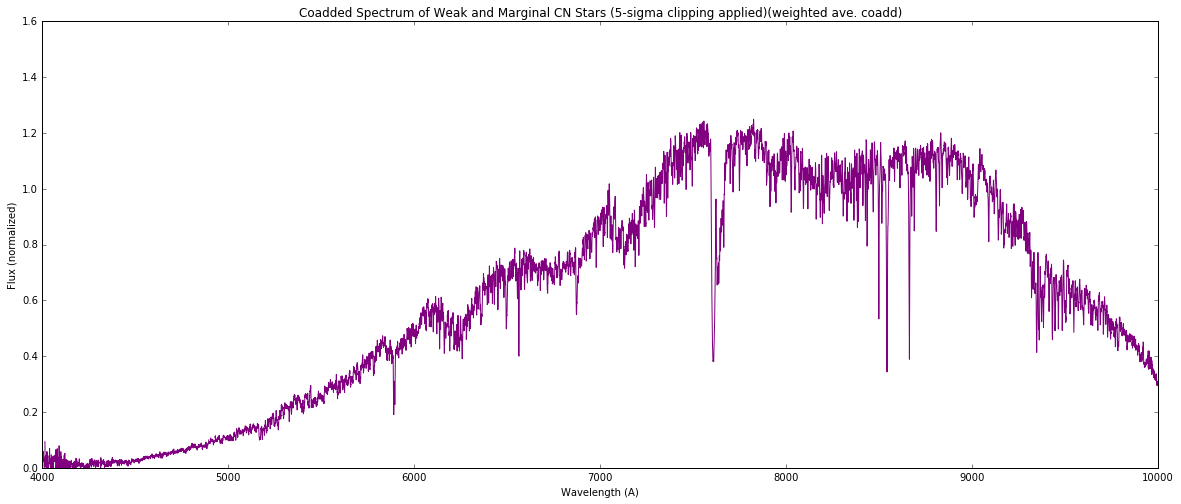

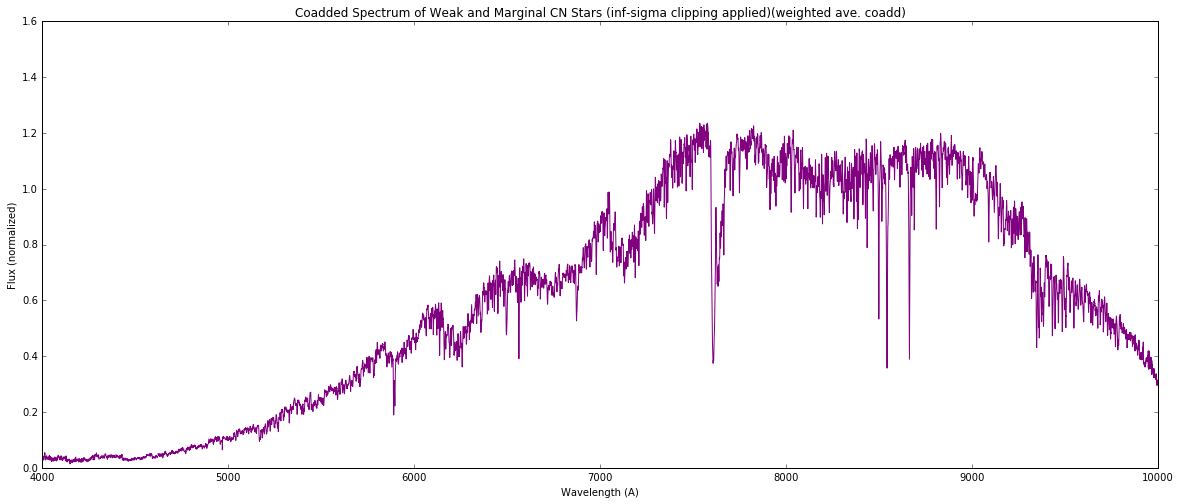

In [38]:
# Visual testing of different amounts/methods of clipspec; surprisingly, simple coaddition with inf-sigma (no clipspec)
# seems to yield the cleanest spectrum.

py.rcParams['figure.figsize'] = 20, 8
py.plot(wv, wNmCoadd3med, 'purple')
py.title('Coadded Spectrum of Weak and Marginal CN Stars (3-sigma clipping applied)(median coadd)')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.6])

py.figure(2)
py.plot(wv, clipspec5, 'purple')
py.title('Coadded Spectrum of Weak and Marginal CN Stars (5-sigma clipping applied)(weighted ave. coadd)')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
# py.xlim([7000, 7100])
py.ylim([0, 1.6])

py.figure(3)
py.plot(wv, coaddspec, 'purple')
py.title('Coadded Spectrum of Weak and Marginal CN Stars (inf-sigma clipping applied)(weighted ave. coadd)')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
# py.xlim([7000, 7100])
py.ylim([0, 1.6])




In [39]:
# This is good! Now do a coaddtion of strong carbon, and non-carbons that fall in same area as weak/marginal carbon stars on CMD, AND n
# non-carbons that fall in same area as strong carbon stars on CMD

In [40]:
weakCy = weakCNdata['F160W']
weakCx = weakCNdata['F814W'] - weakCNdata['F160W']
strongCy = Cdata['F160W']
strongCx = Cdata['F814W'] - Cdata['F160W']

In [41]:
# Lines to determine edges of weak/marginal and strong bins

m = (19 - -52.965)/(2.03045-10)     # Slope of Phil's line, derived from the two points on A^3's plot


# 
x1 = np.arange(1.405, 1.72, .01)
x2 = np.arange(1.925, 2.24, .01)
x3 = np.arange(2.215, 2.374, .005)
x4 = np.arange(2.793, 2.945, .005)
x5 = np.arange(1.09, 1.405, .005)
x6 = np.arange(1.61, 1.925, .005)
x7 = np.arange(2.056, 2.215, .005)
x8 = np.arange(2.63, 2.790, .005)
x9 = np.arange(2.675, 2.99, .01)
x10 = np.arange(3.195, 3.51, .01)
xPhil = np.arange(1, 3, .01)

# Equations of lines determined by using slope of Phil's line, and some guess and check work to find proper y-intercept
y1 = m*x1 + 32
y2 = m*x2 + 36.7
y3 = m*x3 + 37.9
y4 = m*x4 + 43.1
y5 = m*x5 + 32
y6 = m*x6 + 36.7
y7 = m*x7 + 37.9
y8 = m*x8 + 43.1
y9 = m*x9 + 43.45
y10 = m*x10 + 48.15
yPhil = m*xPhil - 2.0345*m + 19     # equation of phil's line
m

-9.029995420067634

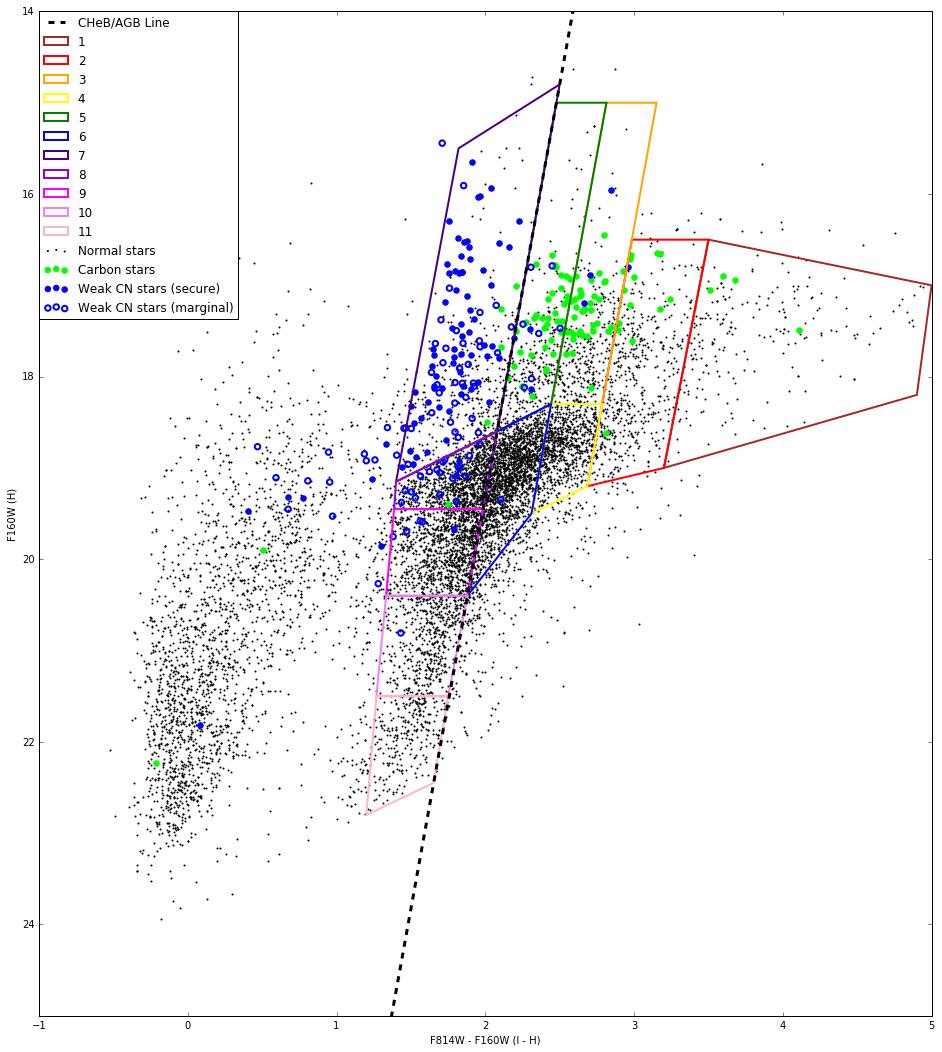

In [45]:
# Plotting all types of stars on H vs. I-H, and defining different bins determined by the slope of phil's line

py.rcParams['figure.figsize'] = 16,18
mm.cmd_plot2(ncData, range(len(ncData)), 1, 'k', label = 'Normal stars') #NONCARBON stars are BLACK and smaller
mm.cmd_plot2(Cdata, range(len(Cdata)), 30, 'lime', label = 'Carbon stars') #carbon stars are LIME
mm.cmd_plot2(wcData, range(len(wcData)), 30, 'b', label = 'Weak CN stars (secure)') #WEAK carbon stars are BLUE
py.scatter(marData.F814W[range(len(marData))] - marData.F160W[range(len(marData))], marData.F160W[range(len(marData))], s=30, linewidth = 2, edgecolors = 'b', facecolors = 'none', label = 'Weak CN stars (marginal)') #MARGINAL carbon stars are open blue 

py.plot(xPhil, yPhil, color = 'k', linewidth = 3, linestyle = '--', label = 'CHeB/AGB Line')

bin1 = py.Polygon([[3.2, 19.], [3.50, 16.5], [4.999, 17], [4.9, 18.2]], color = 'brown', fill = False, label ='1', linewidth = 2)
bin1path = Path([[3.2, 19.], [3.50, 16.5], [4.999, 17], [4.9, 18.2]])
py.gca().add_patch(bin1)

bin2 = py.Polygon([[2.985, 16.5], [2.685, 19.2], [3.2, 19.], [3.50, 16.5]], color = 'red', fill = False, label ='2', linewidth = 2)
bin2path = Path([[2.99, 16.5], [2.685, 19.2], [3.2, 19.], [3.50, 16.5]])
py.gca().add_patch(bin2)
# mask = bin5.contains_point([1,0])

bin3 = py.Polygon([[2.814, 15], [3.1506, 15], [2.785, 18.3], [2.442, 18.3]], color = 'orange', fill = False, label ='3', linewidth = 2)
bin3path = Path([[2.814, 15], [3.1506, 15], [2.785, 18.3], [2.442, 18.3]])
py.gca().add_patch(bin3)

bin4 = py.Polygon([[2.442, 18.3], [2.785, 18.3], [2.685, 19.2], [2.31, 19.5]], color = 'yellow', fill = False, label ='4', linewidth = 2)
bin4path = Path([[2.442, 18.3], [2.785, 18.3], [2.685, 19.2], [2.31, 19.5]])
py.gca().add_patch(bin4)

bin5 = py.Polygon([[2.477468, 15], [2.814, 15], [2.442, 18.3], [2.079, 18.6]], color = 'green', fill = False, label ='5', linewidth = 2)
bin5path = Path([[2.477468, 15], [2.814, 15], [2.442, 18.3], [2.079, 18.6]])
py.gca().add_patch(bin5)

bin6 = py.Polygon([[2.079, 18.6], [2.442, 18.3], [2.31, 19.5], [1.8795, 20.4]], color = 'blue', fill = False, label ='6', linewidth = 2)
bin6path = Path([[2.079, 18.6], [2.442, 18.3], [2.31, 19.5], [1.8795, 20.4]])
py.gca().add_patch(bin6)

bin7 = py.Polygon([[1.4,19.15],[2.079, 18.6],[2.4996,14.8],[1.82,15.5]], color = 'indigo', fill = False, label = '7', linewidth = 2)
bin7path = Path([[1.4,19.15],[2.079, 18.6],[2.4996,14.8],[1.82,15.5]])
py.gca().add_patch(bin7)

bin8 = py.Polygon([[1.4,19.15],[2.079, 18.6],[1.985, 19.45],[1.387,19.45]], color = 'darkviolet', fill = False, label = '8', linewidth = 2)
bin8path = Path([[1.4,19.15],[2.079, 18.6],[1.985, 19.45],[1.387,19.45]])
py.gca().add_patch(bin8)

bin9 = py.Polygon([[1.387,19.45],[1.985, 19.45],[1.8795, 20.4],[1.333, 20.4]], color = 'magenta', fill = False, label = '9', linewidth = 2)
bin9path = Path([[1.387,19.45],[1.985, 19.45],[1.8795, 20.4],[1.333, 20.4]])
py.gca().add_patch(bin9)

bin10 = py.Polygon([[1.333, 20.4],[1.8795, 20.4],[1.75,21.5],[1.268,21.5]], color = 'violet', fill = False, label = '10', linewidth = 2)
bin10path = Path([[1.333, 20.4],[1.8795, 20.4],[1.75,21.5],[1.268,21.5]])
py.gca().add_patch(bin10)

bin11 = py.Polygon([[1.268,21.5],[1.75,21.5],[1.6524,22.45],[1.2,22.8]], color = 'lightpink', fill = False, label = '11', linewidth = 2)
bin11path = Path([[1.268,21.5],[1.75,21.5],[1.6524,22.45],[1.2,22.8]])
py.gca().add_patch(bin11)



# refPoint= py.scatter(2, 18.5, s=100, color = 'magenta')
# refPoint2= py.scatter(2.8455, 17.75, s=100, color = 'orange')


py.xlim(-1, 5)
py.ylim(25, 14)

py.xlabel('F814W - F160W (I - H)')
py.ylabel('F160W (H)')
py.legend(bbox_to_anchor=(.23, 1.006))

In [57]:
# Extract indices for non-carbon stars within each bin. This cell takes quite a while to run..NOTE: these indices are for non-carbon .fits file!

bin1Indices = [i for i in range(len(ncData)) if bin1path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin2Indices = [i for i in range(len(ncData)) if bin2path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin3Indices = [i for i in range(len(ncData)) if bin3path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin4Indices = [i for i in range(len(ncData)) if bin4path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin5Indices = [i for i in range(len(ncData)) if bin5path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin6Indices = [i for i in range(len(ncData)) if bin6path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin7Indices = [i for i in range(len(ncData)) if bin7path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin8Indices = [i for i in range(len(ncData)) if bin8path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin9Indices = [i for i in range(len(ncData)) if bin9path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin10Indices = [i for i in range(len(ncData)) if bin10path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]
bin11Indices = [i for i in range(len(ncData)) if bin11path.contains_point([ncData['F814W'][i] - ncData['F160W'][i], ncData['F160W'][i]])
              and ~np.any(ncData['FULLNAME'][i] == clusterData['FULLNAME'])]


In [58]:
# Extract indices for C stars within bins that contain majority of C stars. NOTE: these indices are for the 'strong carbon' .fits file!

bin3Cindices = np.array([i for i in range(len(Cdata)) if bin3path.contains_point([Cdata['F814W'][i] - Cdata['F160W'][i], Cdata['F160W'][i]])
               and ~np.any(Cdata['FULLNAME'][i] == clusterData['FULLNAME'])])
bin5Cindices = np.array([i for i in range(len(Cdata)) if bin5path.contains_point([Cdata['F814W'][i] - Cdata['F160W'][i], Cdata['F160W'][i]])
               and ~np.any(Cdata['FULLNAME'][i] == clusterData['FULLNAME'])])

bin1_2Cindices = np.array([i for i in range(len(Cdata)) if (bin1path.contains_point([Cdata['F814W'][i] - Cdata['F160W'][i], Cdata['F160W'][i]])
                 | bin2path.contains_point([Cdata['F814W'][i] - Cdata['F160W'][i], Cdata['F160W'][i]])) 
                 and ~np.any(Cdata['FULLNAME'][i] == clusterData['FULLNAME'])])

# All carbon stars to the left of the Rosenfield (CHeB/AGB) line
binLeftCindices = [i for i in range(len(Cdata)) if ~np.any(i == bin3Cindices) and ~np.any(i == bin5Cindices) and ~np.any(i == bin1_2Cindices)]



In [59]:
binLeftCindices

[5, 10, 11, 17, 78, 90, 93]

In [60]:
# Extract indices for weak CN stars within bins that contain the majority of weak CN stars. NOTE: these indices are for the weakCNdata object!

bin3_5weakCNind = np.array([i for i in range(len(weakCNdata)) if (bin3path.contains_point([weakCNdata['F814W'][i] - weakCNdata['F160W'][i], weakCNdata['F160W'][i]]) or 
                  bin5path.contains_point([weakCNdata['F814W'][i] - weakCNdata['F160W'][i], weakCNdata['F160W'][i]]) or 
                  bin6path.contains_point([weakCNdata['F814W'][i] - weakCNdata['F160W'][i], weakCNdata['F160W'][i]]))                                       
                  and ~np.any(weakCNdata['FULLNAME'][i] == clusterData['FULLNAME'])])

bin7weakCNind = np.array([i for i in range(len(weakCNdata)) if bin7path.contains_point([weakCNdata['F814W'][i] - weakCNdata['F160W'][i], weakCNdata['F160W'][i]])
                and ~np.any(weakCNdata['FULLNAME'][i] == clusterData['FULLNAME'])])
bin8weakCNind = np.array([i for i in range(len(weakCNdata)) if bin8path.contains_point([weakCNdata['F814W'][i] - weakCNdata['F160W'][i], weakCNdata['F160W'][i]])
                and ~np.any(weakCNdata['FULLNAME'][i] == clusterData['FULLNAME'])])
bin9weakCNind = np.array([i for i in range(len(weakCNdata)) if bin9path.contains_point([weakCNdata['F814W'][i] - weakCNdata['F160W'][i], weakCNdata['F160W'][i]])
                and ~np.any(weakCNdata['FULLNAME'][i] == clusterData['FULLNAME'])])
bin10weakCNind = np.array([i for i in range(len(weakCNdata)) if bin10path.contains_point([weakCNdata['F814W'][i] - weakCNdata['F160W'][i], weakCNdata['F160W'][i]])
                and ~np.any(weakCNdata['FULLNAME'][i] == clusterData['FULLNAME'])])
bin11weakCNind = np.array([i for i in range(len(weakCNdata)) if bin11path.contains_point([weakCNdata['F814W'][i] - weakCNdata['F160W'][i], weakCNdata['F160W'][i]])
                and ~np.any(weakCNdata['FULLNAME'][i] == clusterData['FULLNAME'])])

binLeftweakCNind = np.array([i for i in range(len(weakCNdata)) if ~np.any(i == bin3_5weakCNind) and ~np.any(i == bin7weakCNind) and ~np.any(i == bin8weakCNind) 
                    and ~np.any(i == bin9weakCNind) and ~np.any(i == bin10weakCNind) and ~np.any(i == bin11weakCNind) and ~np.any(i == bin7weakCNind)
                    and ~np.any(weakCNdata['FULLNAME'][i] == clusterData['FULLNAME']) and ((weakCNdata['F814W'][i] - weakCNdata['F160W'][i]) < 2)])
len(binLeftweakCNind)


21

In [61]:
5 == np.array(bin7weakCNind)

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False], dtype=bool)

In [62]:
bin1data = ncData[bin1Indices]
bin2data = ncData[bin2Indices]
bin3data = ncData[bin3Indices]
bin4data = ncData[bin4Indices]
bin5data = ncData[bin5Indices]
bin6data = ncData[bin6Indices]
bin7data = ncData[bin7Indices]
bin8data = ncData[bin8Indices]
bin9data = ncData[bin9Indices]
bin10data = ncData[bin10Indices]
bin11data = ncData[bin11Indices]


bin3Cdata = Cdata[bin3Cindices]
bin5Cdata = Cdata[bin5Cindices]
bin1_2Cdata = Cdata[bin1_2Cindices]
binLeftCdata = Cdata[binLeftCindices]


bin3_5weakCNdata = weakCNdata[bin3_5weakCNind]
bin7weakCNdata = weakCNdata[bin7weakCNind]
bin8weakCNdata = weakCNdata[bin8weakCNind]
bin9weakCNdata = weakCNdata[bin9weakCNind]
binLeftweakCNdata = weakCNdata[binLeftweakCNind]
# bin10weakCNdata = weakCNdata[bin10weakCNind]
# bin11weakCNdata = weakCNdata[bin11weakCNind]




In [63]:

bin_7_subMaster_indices = [i for i in range(len(data)) if np.any(data['FULLNAME'][i] == bin7data['FULLNAME'])]    


In [64]:
len(binLeftweakCNdata)


21

In [65]:
np.save('bin_7_subMaster_indices.npy', bin_7_subMaster_indices)

In [66]:
bin1X = bin1data['F814W'] - bin1data['F160W']
bin1Y = bin1data['F160W']

bin9X = bin9data['F814W'] - bin9data['F160W']
bin9Y = bin9data['F160W']

bin10X = bin10data['F814W'] - bin10data['F160W']
bin10Y = bin10data['F160W']

bin11X = bin11data['F814W'] - bin11data['F160W']
bin11Y = bin11data['F160W']

bin8X = bin8data['F814W'] - bin8data['F160W']
bin8Y = bin8data['F160W']

bin7X = bin7data['F814W'] - bin7data['F160W']
bin7Y = bin7data['F160W']


bin3CX = bin3Cdata['F814W'] - bin3Cdata['F160W']
bin3CY = bin3Cdata['F160W']

bin5CX = bin5Cdata['F814W'] - bin5Cdata['F160W']
bin5CY = bin5Cdata['F160W']

bin3_5wCNX = bin3_5weakCNdata['F814W'] - bin3_5weakCNdata['F160W']
bin3_5wCNY = bin3_5weakCNdata['F160W']

binLeftwCNX = binLeftweakCNdata['F814W'] - binLeftweakCNdata['F160W']
binLeftwCNY = binLeftweakCNdata['F160W']

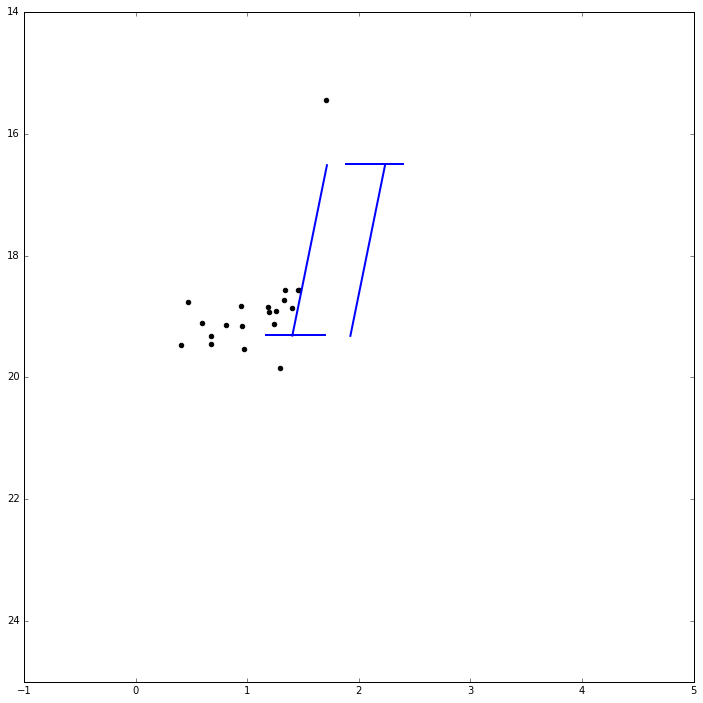

In [67]:
# This block can be used to visually test to see if non-carbon populations fall within desired bins..i.e. ERROR check

py.rcParams['figure.figsize'] = 12, 12
py.xlim([-1, 5])
py.ylim([25, 14])
# py.scatter(bin3data['F814W'] - bin3data['F160W'], bin3data['F160W'], color = 'k')

# Weak/marginal bin
scat1 = py.scatter(binLeftwCNX, binLeftwCNY, color = 'k', label = 'Non-carbon stars')
py.plot(x1, y1, 'blue', linewidth = 2)
py.plot(x2, y2, 'blue', linewidth = 2)
py.plot([1.89, 2.4], [16.5, 16.5], 'blue', linewidth = 2)
py.plot([1.165, 1.7], [19.3, 19.3], 'blue', linewidth = 2)

# # Strong Carbon bin
# py.scatter(strongZoneX, strongZoneY, color = 'k')
# py.plot(x3, y3, 'green', linewidth = 2)
# py.plot(x4, y4, 'green', linewidth = 2)
# py.plot([2.45, 3.080], [16.7, 16.7], 'green', linewidth = 2)
# py.plot([2.16, 2.8], [17.8, 17.8], 'green', linewidth = 2)

# py.scatter(bin3X, bin3Y, color = 'k')
# py.plot(x3, y3, 'green', linewidth = 2)
# py.plot(x4, y4, 'green', linewidth = 2)
# py.plot([2.45, 3.080], [16.7, 16.7], 'green', linewidth = 2)
# py.plot([2.16, 2.8], [17.8, 17.8], 'green', linewidth = 2)

# py.xlabel('F814W - F160W (I - H)')
# py.ylabel('F160W (H)')
# py.legend(handles=[scat1])



In [68]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #1

fluxnorm1 = []
ivarnorm1 = []
for i in range(len(bin1data)):
    [fluxtemp, ivartemp ] = mm.normal(bin1data['SPEC'][i], bin1data['IVAR'][i])
    fluxnorm1 += [fluxtemp]
    ivarnorm1 += [ivartemp]
fluxnorm1 = np.array(fluxnorm1)
ivarnorm1 = np.array(ivarnorm1)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [69]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #2

fluxnorm2 = []
ivarnorm2 = []
for i in range(len(bin2data)):
    [fluxtemp, ivartemp ] = mm.normal(bin2data['SPEC'][i], bin2data['IVAR'][i])
    fluxnorm2 += [fluxtemp]
    ivarnorm2 += [ivartemp]
fluxnorm2 = np.array(fluxnorm2)
ivarnorm2 = np.array(ivarnorm2)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [70]:
# Normalizing spectra and ivar of carbon stars residing in bins 1 and 2

fluxnorm1_2C = []
ivarnorm1_2C = []
for i in range(len(bin1_2Cdata)):
    [fluxtemp, ivartemp ] = mm.normal(bin1_2Cdata['SPEC'][i], bin1_2Cdata['IVAR'][i])
    fluxnorm1_2C += [fluxtemp]
    ivarnorm1_2C += [ivartemp]
fluxnorm1_2C = np.array(fluxnorm1_2C)
ivarnorm1_2C = np.array(ivarnorm1_2C)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [71]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #3

fluxnorm3 = []
ivarnorm3 = []
for i in range(len(bin3data)):
    [fluxtemp, ivartemp ] = mm.normal(bin3data['SPEC'][i], bin3data['IVAR'][i])
    fluxnorm3 += [fluxtemp]
    ivarnorm3 += [ivartemp]
fluxnorm3 = np.array(fluxnorm3)
ivarnorm3 = np.array(ivarnorm3)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [72]:
# Normalizing spectra and ivar of carbon stars residing in bin #3

fluxnorm3C = []
ivarnorm3C = []
for i in range(len(bin3Cdata)):
    [fluxtemp, ivartemp ] = mm.normal(bin3Cdata['SPEC'][i], bin3Cdata['IVAR'][i])
    fluxnorm3C += [fluxtemp]
    ivarnorm3C+= [ivartemp]
fluxnorm3C = np.array(fluxnorm3C)
ivarnorm3C = np.array(ivarnorm3C)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [73]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #4

fluxnorm4 = []
ivarnorm4 = []
for i in range(len(bin4data)):
    [fluxtemp, ivartemp ] = mm.normal(bin4data['SPEC'][i], bin4data['IVAR'][i])
    fluxnorm4 += [fluxtemp]
    ivarnorm4 += [ivartemp]
fluxnorm4 = np.array(fluxnorm4)
ivarnorm4 = np.array(ivarnorm4)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [74]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #5

fluxnorm5 = []
ivarnorm5 = []
for i in range(len(bin5data)):
    [fluxtemp, ivartemp ] = mm.normal(bin5data['SPEC'][i], bin5data['IVAR'][i])
    fluxnorm5 += [fluxtemp]
    ivarnorm5 += [ivartemp]
fluxnorm5 = np.array(fluxnorm5)
ivarnorm5 = np.array(ivarnorm5)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [75]:
# Normalizing spectra and ivar of carbon stars residing in bin #5

fluxnorm5C = []
ivarnorm5C = []
for i in range(len(bin5Cdata)):
    [fluxtemp, ivartemp ] = mm.normal(bin5Cdata['SPEC'][i], bin5Cdata['IVAR'][i])
    fluxnorm5C += [fluxtemp]
    ivarnorm5C+= [ivartemp]
fluxnorm5C = np.array(fluxnorm5C)
ivarnorm5C = np.array(ivarnorm5C)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [76]:
# Normalizing spectra and ivar of carbon stars residing to the left of the CHeB/AGB (Phil's) line

fluxnormLeftC = []
ivarnormLeftC = []
for i in range(len(binLeftCdata)):
    [fluxtemp, ivartemp ] = mm.normal(binLeftCdata['SPEC'][i], binLeftCdata['IVAR'][i])
    fluxnormLeftC += [fluxtemp]
    ivarnormLeftC+= [ivartemp]
fluxnormLeftC = np.array(fluxnormLeftC)
ivarnormLeftC = np.array(ivarnormLeftC)

In [77]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #6

fluxnorm6 = []
ivarnorm6 = []
for i in range(len(bin6data)):
    [fluxtemp, ivartemp ] = mm.normal(bin6data['SPEC'][i], bin6data['IVAR'][i])
    fluxnorm6 += [fluxtemp]
    ivarnorm6 += [ivartemp]
fluxnorm6 = np.array(fluxnorm6)
ivarnorm6 = np.array(ivarnorm6)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [78]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #7

fluxnorm7 = []
ivarnorm7 = []
for i in range(len(bin7data)):
    [fluxtemp, ivartemp ] = mm.normal(bin7data['SPEC'][i], bin7data['IVAR'][i])
    fluxnorm7 += [fluxtemp]
    ivarnorm7 += [ivartemp]
fluxnorm7 = np.array(fluxnorm7)
ivarnorm7 = np.array(ivarnorm7)

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [79]:
# Normalizing spectra and ivar of weak CN stars residing in bin #7

fluxnorm7weakCN = []
ivarnorm7weakCN = []
for i in range(len(bin7weakCNdata)):
    [fluxtemp, ivartemp ] = mm.normal(bin7weakCNdata['SPEC'][i], bin7weakCNdata['IVAR'][i])
    fluxnorm7weakCN += [fluxtemp]
    ivarnorm7weakCN += [ivartemp]
fluxnorm7weakCN = np.array(fluxnorm7weakCN)
ivarnorm7weakCN = np.array(ivarnorm7weakCN)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [80]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #8

fluxnorm8 = []
ivarnorm8 = []
for i in range(len(bin8data)):
    [fluxtemp, ivartemp ] = mm.normal(bin8data['SPEC'][i], bin8data['IVAR'][i])
    fluxnorm8 += [fluxtemp]
    ivarnorm8 += [ivartemp]
fluxnorm8 = np.array(fluxnorm8)
ivarnorm8 = np.array(ivarnorm8)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [81]:
# Normalizing spectra and ivar of weak CN stars residing in bin #8

fluxnorm8weakCN = []
ivarnorm8weakCN = []
for i in range(len(bin8weakCNdata)):
    [fluxtemp, ivartemp ] = mm.normal(bin8weakCNdata['SPEC'][i], bin8weakCNdata['IVAR'][i])
    fluxnorm8weakCN += [fluxtemp]
    ivarnorm8weakCN += [ivartemp]
fluxnorm8weakCN = np.array(fluxnorm8weakCN)
ivarnorm8weakCN = np.array(ivarnorm8weakCN)

In [82]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #9

fluxnorm9 = []
ivarnorm9 = []
for i in range(len(bin9data)):
    [fluxtemp, ivartemp ] = mm.normal(bin9data['SPEC'][i], bin9data['IVAR'][i])
    fluxnorm9 += [fluxtemp]
    ivarnorm9 += [ivartemp]
fluxnorm9 = np.array(fluxnorm9)
ivarnorm9 = np.array(ivarnorm9)

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [83]:
# Normalizing spectra and ivar of weak CN stars residing in bin #9

fluxnorm9weakCN = []
ivarnorm9weakCN = []
for i in range(len(bin9weakCNdata)):
    [fluxtemp, ivartemp ] = mm.normal(bin9weakCNdata['SPEC'][i], bin9weakCNdata['IVAR'][i])
    fluxnorm9weakCN += [fluxtemp]
    ivarnorm9weakCN += [ivartemp]
fluxnorm9weakCN = np.array(fluxnorm9weakCN)
ivarnorm9weakCN = np.array(ivarnorm9weakCN)

In [84]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #10

fluxnorm10 = []
ivarnorm10 = []
for i in range(len(bin10data)):
    [fluxtemp, ivartemp ] = mm.normal(bin10data['SPEC'][i], bin10data['IVAR'][i])
    fluxnorm10 += [fluxtemp]
    ivarnorm10 += [ivartemp]
fluxnorm10 = np.array(fluxnorm10)
ivarnorm10 = np.array(ivarnorm10)

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [85]:
# Normalizing spectra and ivar of non-carbon stars residing in bin #11

fluxnorm11 = []
ivarnorm11 = []
for i in range(len(bin11data)):
    [fluxtemp, ivartemp ] = mm.normal(bin11data['SPEC'][i], bin11data['IVAR'][i])
    fluxnorm11 += [fluxtemp]
    ivarnorm11 += [ivartemp]
fluxnorm11 = np.array(fluxnorm11)
ivarnorm11 = np.array(ivarnorm11)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData


In [86]:
# Normalizing spectra and ivar of all carbon stars 

fluxnormC = []
ivarnormC = []
for i in range(len(Cdata)):
    [fluxtemp, ivartemp ] = mm.normal(Cdata['SPEC'][i], Cdata['IVAR'][i])
    fluxnormC += [fluxtemp]
    ivarnormC += [ivartemp]
fluxnormC = np.array(fluxnormC)
ivarnormC = np.array(ivarnormC)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [87]:
fluxnormLeftCN = []
ivarnormLeftCN = []
for i in range(len(binLeftweakCNdata)):
    [fluxtemp, ivartemp ] = mm.normal(binLeftweakCNdata['SPEC'][i], binLeftweakCNdata['IVAR'][i])
    fluxnormLeftCN += [fluxtemp]
    ivarnormLeftCN += [ivartemp]
fluxnormLeftCN = np.array(fluxnormLeftCN)
ivarnormLeftCN = np.array(ivarnormLeftCN)

In [88]:
fluxnormNonC = []
ivarnormNonC = []
for i in range(len(ncData)):
    [fluxtemp, ivartemp ] = mm.normal(ncData['SPEC'][i], ncData['IVAR'][i])
    fluxnormNonC += [fluxtemp]
    ivarnormNonC += [ivartemp]
fluxnormNonC = np.array(fluxnormNonC)
ivarnormNonC = np.array(ivarnormNonC)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:99: RuntimeWarning: divide by zero encountered in true_divide
  nor = 1 / np.median(centralSpec)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:100: RuntimeWarning: invalid value encountered in multiply
  normalSpec = nor*specData
//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [89]:
gauss = Gaussian1DKernel(1.5)

In [90]:
# Coadding spectra of non-carbon populations within indicated bin using 3-sigma clipping and median coadd method

bin1Coadd = mm.coadd_med(fluxnorm1, ivarnorm1, wv)
bin2Coadd = mm.coadd_med(fluxnorm2, ivarnorm2, wv)
bin3Coadd = mm.coadd_med(fluxnorm3, ivarnorm3, wv)
bin4Coadd = mm.coadd_med(fluxnorm4, ivarnorm4, wv)
bin5Coadd = mm.coadd_med(fluxnorm5, ivarnorm5, wv)
bin6Coadd = mm.coadd_med(fluxnorm6, ivarnorm6, wv)
bin7Coadd = mm.coadd_med(fluxnorm7, ivarnorm7, wv)
bin8Coadd = mm.coadd_med(fluxnorm8, ivarnorm8, wv)
bin9Coadd = mm.coadd_med(fluxnorm9, ivarnorm9, wv)
bin10Coadd = mm.coadd_med(fluxnorm10, ivarnorm10, wv)
bin11Coadd = mm.coadd_med(fluxnorm11, ivarnorm11, wv)

normCoadd = mm.coadd_med(fluxnormNonC, ivarnormNonC, wv)

# Gaussian smoothing of coadded spectra of non-carbon populations using sigma = 2 pixels

bin1CoaddSm = convolve(bin1Coadd, gauss)
bin2CoaddSm = convolve(bin2Coadd, gauss)
bin3CoaddSm = convolve(bin3Coadd, gauss)
bin4CoaddSm = convolve(bin4Coadd, gauss)
bin5CoaddSm = convolve(bin5Coadd, gauss)
bin6CoaddSm = convolve(bin6Coadd, gauss)
bin7CoaddSm = convolve(bin7Coadd, gauss)
bin8CoaddSm = convolve(bin8Coadd, gauss)
bin9CoaddSm = convolve(bin9Coadd, gauss)
bin10CoaddSm = convolve(bin10Coadd, gauss)
bin11CoaddSm = convolve(bin11Coadd, gauss)

normCoaddSm = convolve(normCoadd, gauss)





//anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:739: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:282: RuntimeWarning: invalid value encountered in multiply
  sigdiff=abs(fluxnorm-medflux)*np.sqrt(ivarnorm)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:284: RuntimeWarning: invalid value encountered in greater
  clip[sigdiff>siglim]=0
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:286: RuntimeWarning: invalid value encountered in multiply
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:286: RuntimeWarning: invalid value encountered in true_divide
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:287: RuntimeWarning: divide by zero encountered in tr

In [91]:
# Coadding spectra of carbon and weak CN populations within indicated bin using 3-sigma clipping and median coadd method

bin1_2C_Coadd = mm.coadd_med(fluxnorm1_2C, ivarnorm1_2C, wv)
bin3C_Coadd = mm.coadd_med(fluxnorm3C, ivarnorm3C, wv)
bin5C_Coadd = mm.coadd_med(fluxnorm5C, ivarnorm5C, wv)
binLeftC_Coadd = mm.coadd_med(fluxnormLeftC, ivarnormLeftC, wv)


bin7wCNcoadd = mm.coadd_med(fluxnorm7weakCN, ivarnorm7weakCN, wv)
bin8wCNcoadd = mm.coadd_med(fluxnorm8weakCN, ivarnorm8weakCN, wv)
bin9wCNcoadd = mm.coadd_med(fluxnorm9weakCN, ivarnorm9weakCN, wv)
binLeftwCNcoadd = mm.coadd_med(fluxnormLeftCN, ivarnormLeftCN, wv)

# Gaussian smoothing of coadded spectra of carbon and weak CN populations within indicated bin using sigma = 2 pixels

bin1_2C_CoaddSm = convolve(bin1_2C_Coadd, gauss)
bin3C_CoaddSm = convolve(bin3C_Coadd, gauss)
bin5C_CoaddSm = convolve(bin5C_Coadd, gauss)
binLeftC_CoaddSm = convolve(binLeftC_Coadd, gauss)


bin7wCNcoaddSm = convolve(bin7wCNcoadd, gauss)
bin8wCNcoaddSm = convolve(bin8wCNcoadd, gauss)
bin9wCNcoaddSm = convolve(bin9wCNcoadd, gauss)
binLeftwCNcoaddSm = convolve(binLeftwCNcoadd, gauss)






//anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:739: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:282: RuntimeWarning: invalid value encountered in subtract
  sigdiff=abs(fluxnorm-medflux)*np.sqrt(ivarnorm)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:282: RuntimeWarning: invalid value encountered in multiply
  sigdiff=abs(fluxnorm-medflux)*np.sqrt(ivarnorm)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:284: RuntimeWarning: invalid value encountered in greater
  clip[sigdiff>siglim]=0
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:286: RuntimeWarning: invalid value encountered in multiply
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:286: RuntimeWarning: invalid value encountered in true_divide
  coadd=np.nansum

In [92]:
# Coadding spectra of all weak CN stars 
weakCNcoadd = mm.coadd_med(fluxnorm, ivarnorm, wv)

# Smoothing coadded spectra of all weak CN stars 
weakCNcoaddSm = convolve(weakCNcoadd, gauss)

# enlarged spectrum of smooth weak CN coadd; spectrum is enlarged to try and match amplitude of 'W' in carbon star coadds
weakCNcoaddSmX = (weakCNcoaddSm - .7) / (1 - .7)

/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:282: RuntimeWarning: invalid value encountered in multiply
  sigdiff=abs(fluxnorm-medflux)*np.sqrt(ivarnorm)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:284: RuntimeWarning: invalid value encountered in greater
  clip[sigdiff>siglim]=0
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:286: RuntimeWarning: invalid value encountered in multiply
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:286: RuntimeWarning: invalid value encountered in true_divide
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:287: RuntimeWarning: divide by zero encountered in true_divide
  coadderr=1/np.sqrt(np.nansum(ivarnorm*clip,0))


In [93]:
# Coadding spectra of all carbon stars
carbonCoadd = mm.coadd_med(fluxnormC, ivarnormC, wv)

# Smoothing coadded spectra of all carbon stars 
carbonCoaddSm = convolve(carbonCoadd, gauss)



//anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:739: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:282: RuntimeWarning: invalid value encountered in multiply
  sigdiff=abs(fluxnorm-medflux)*np.sqrt(ivarnorm)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:284: RuntimeWarning: invalid value encountered in greater
  clip[sigdiff>siglim]=0
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:286: RuntimeWarning: invalid value encountered in multiply
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:286: RuntimeWarning: invalid value encountered in true_divide
  coadd=np.nansum((fluxnorm*ivarnorm)*clip,0)/np.nansum(ivarnorm*clip,0)
/Users/jonhays/Documents/ASTRO/Python notebooks/myAstroMods.py:287: RuntimeWarning: divide by zero encountered in tr

(0, 1.5)

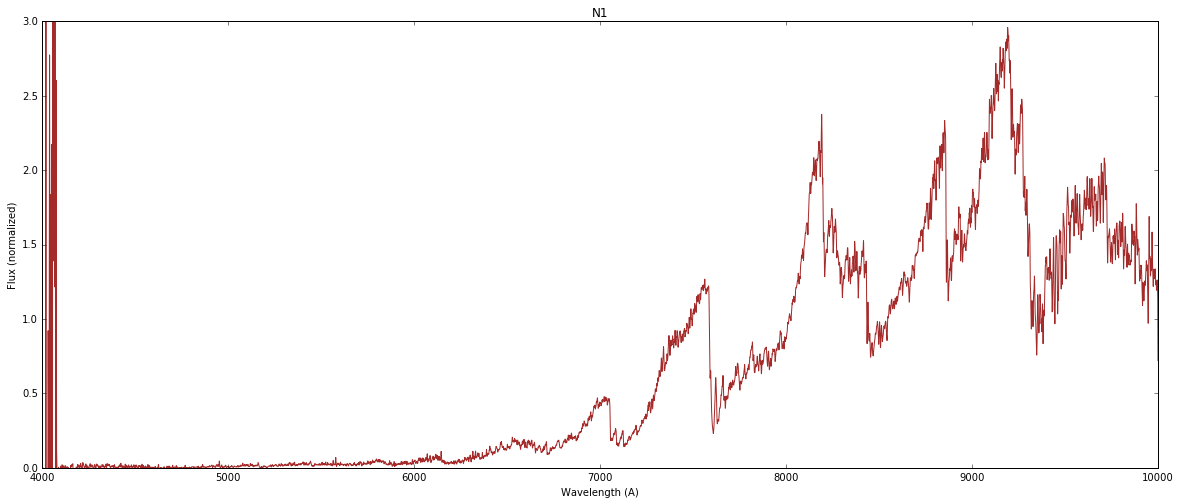

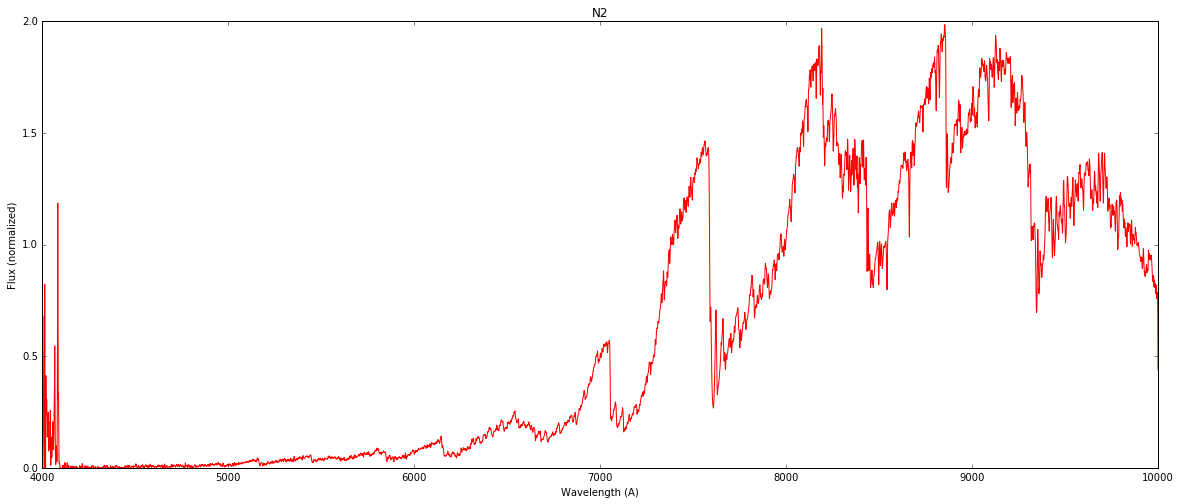

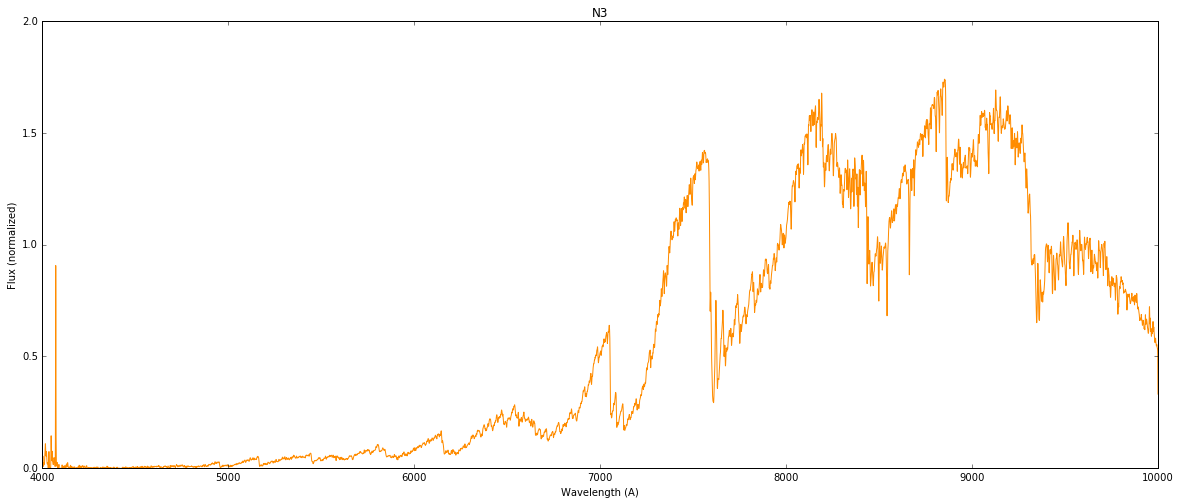

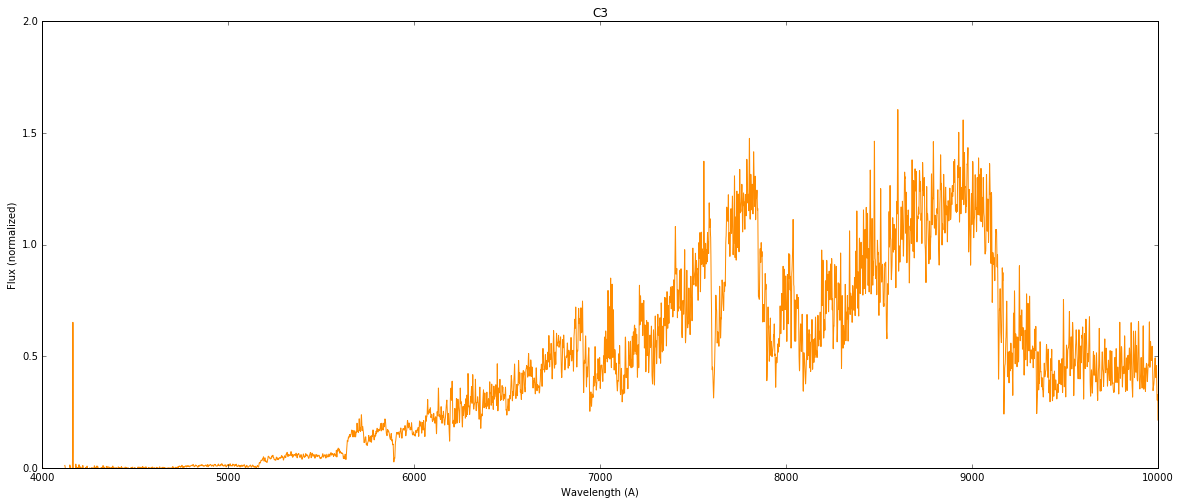

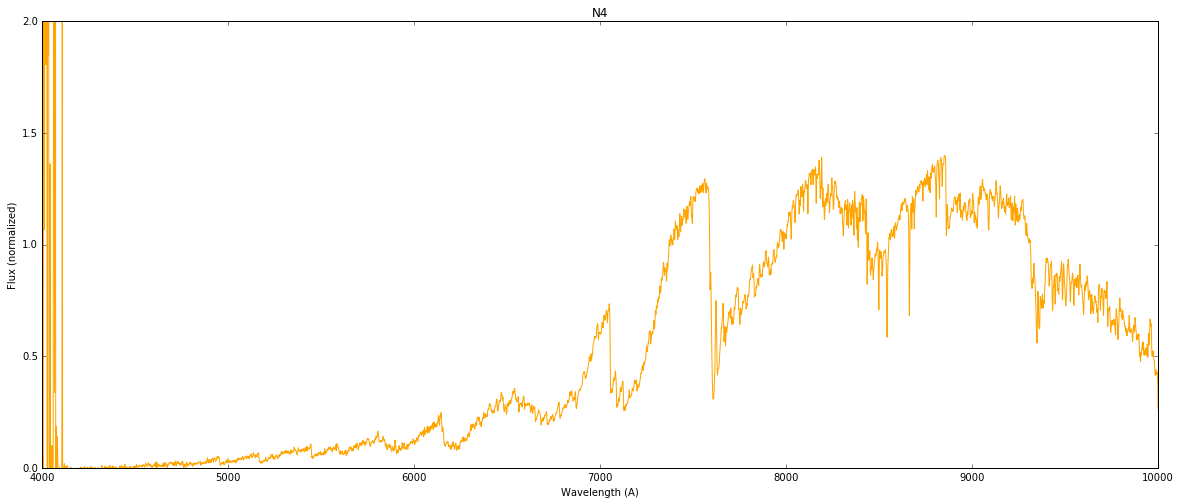

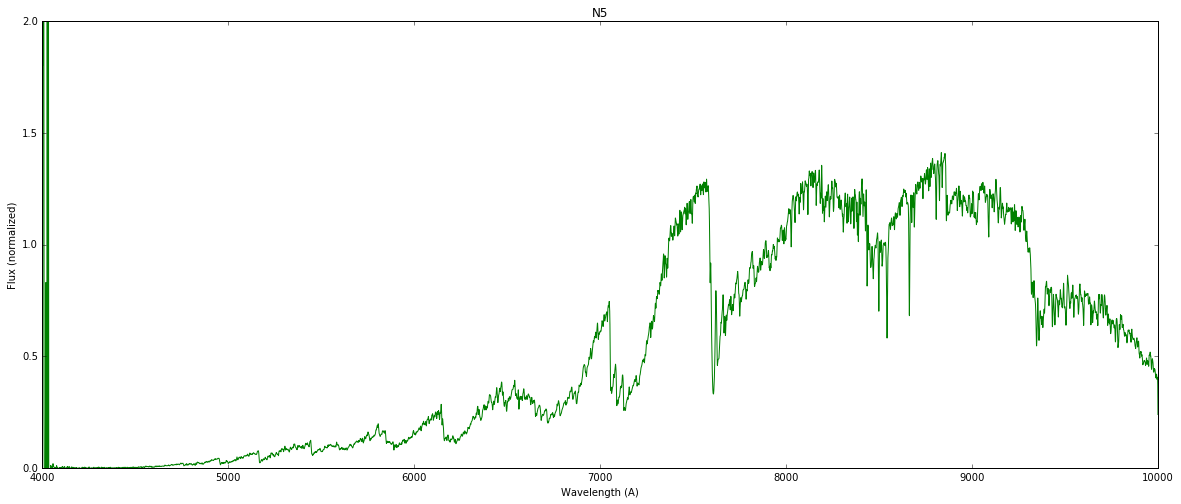

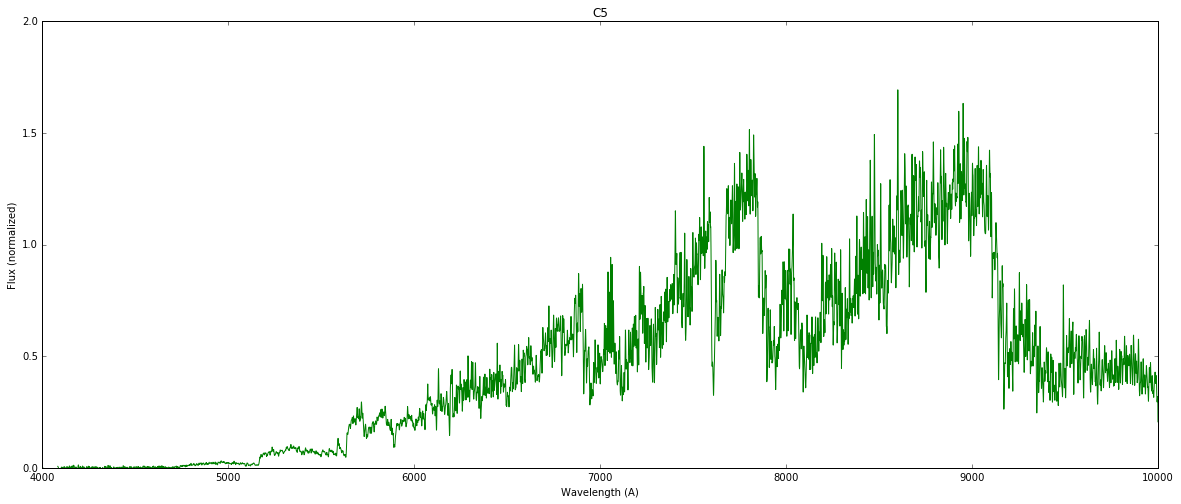

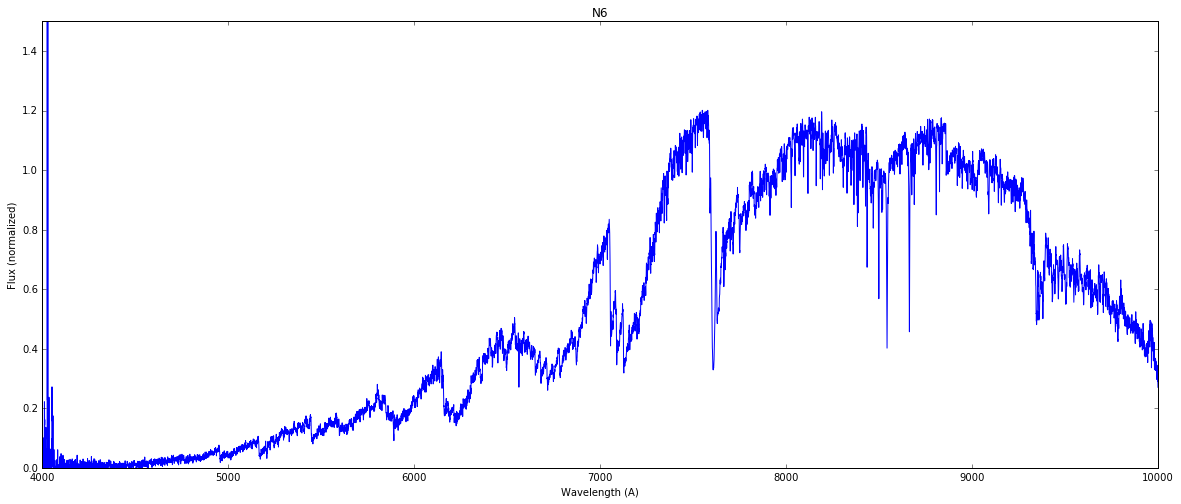

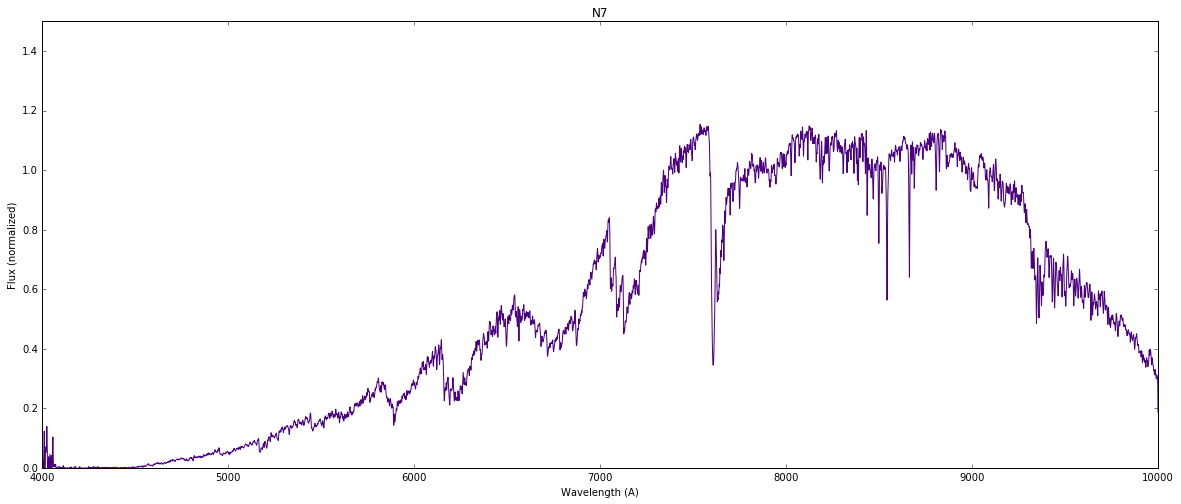

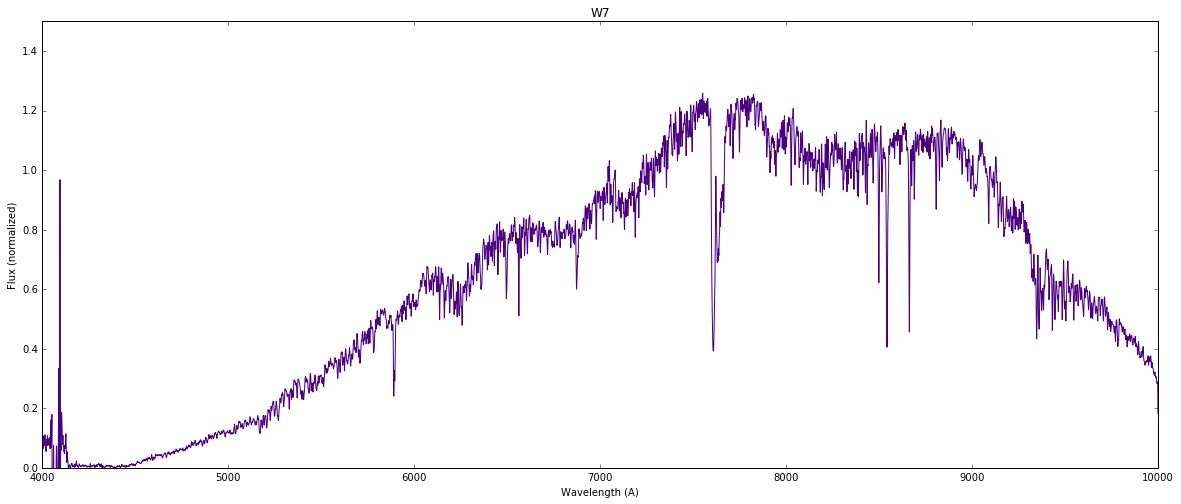

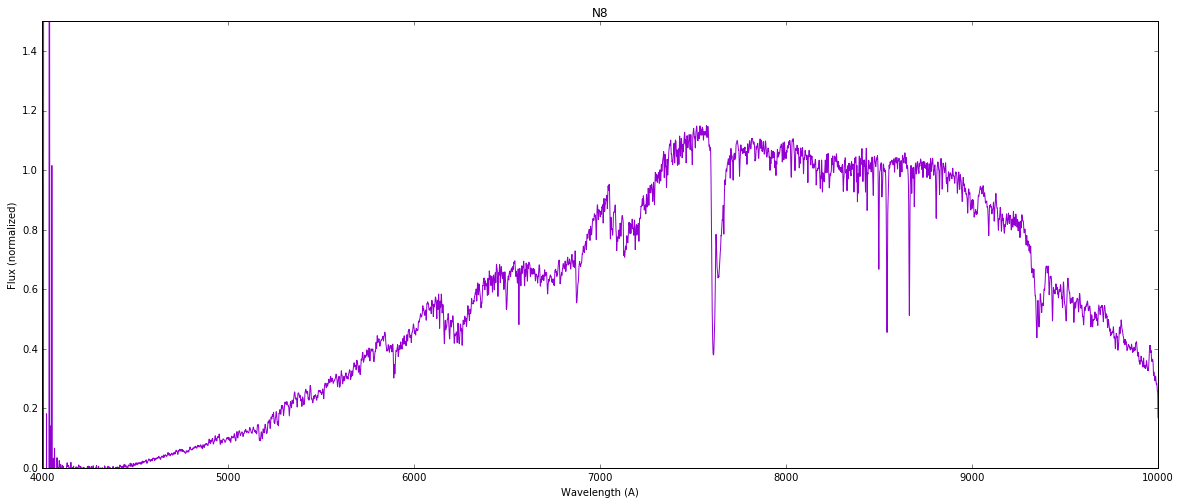

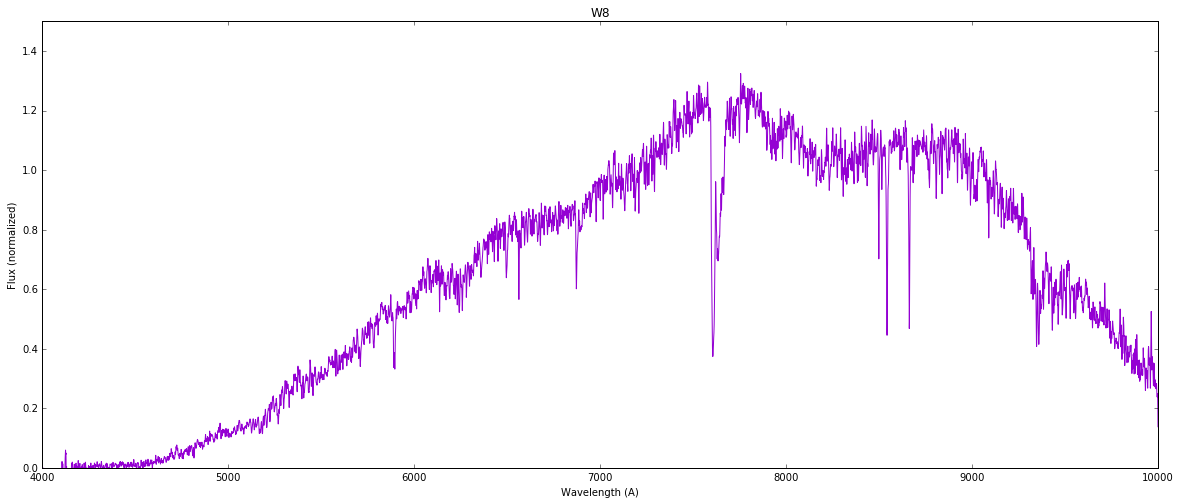

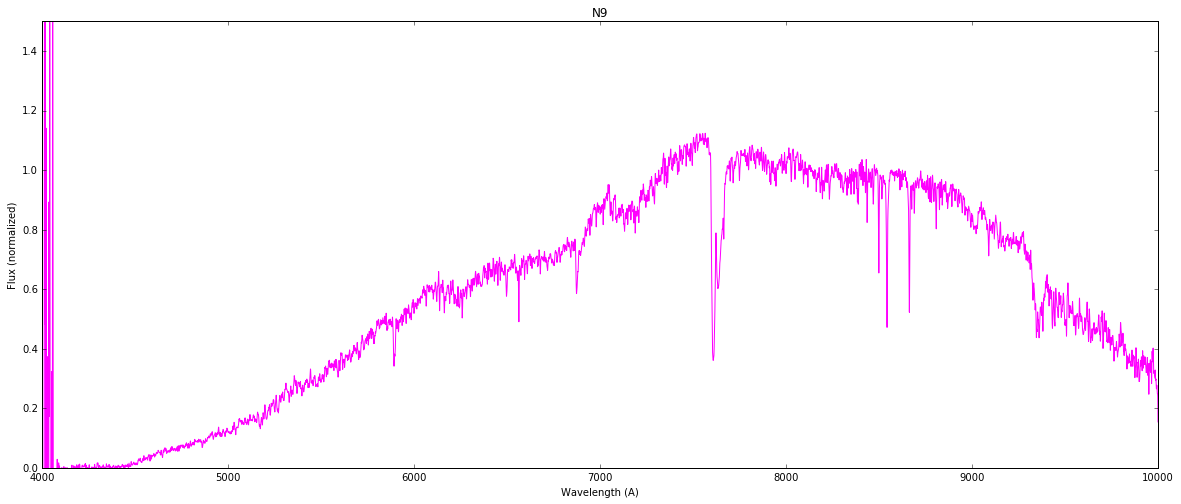

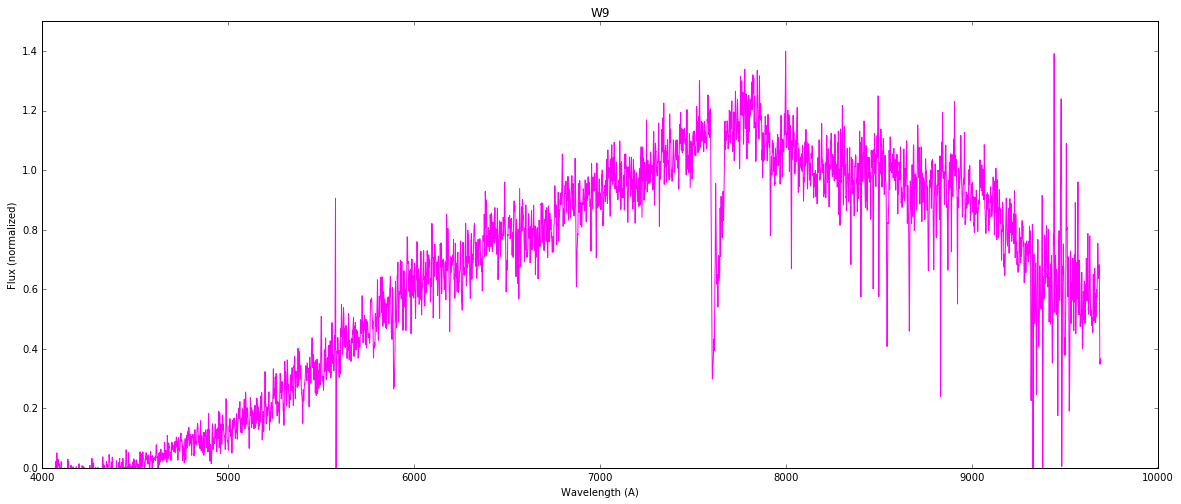

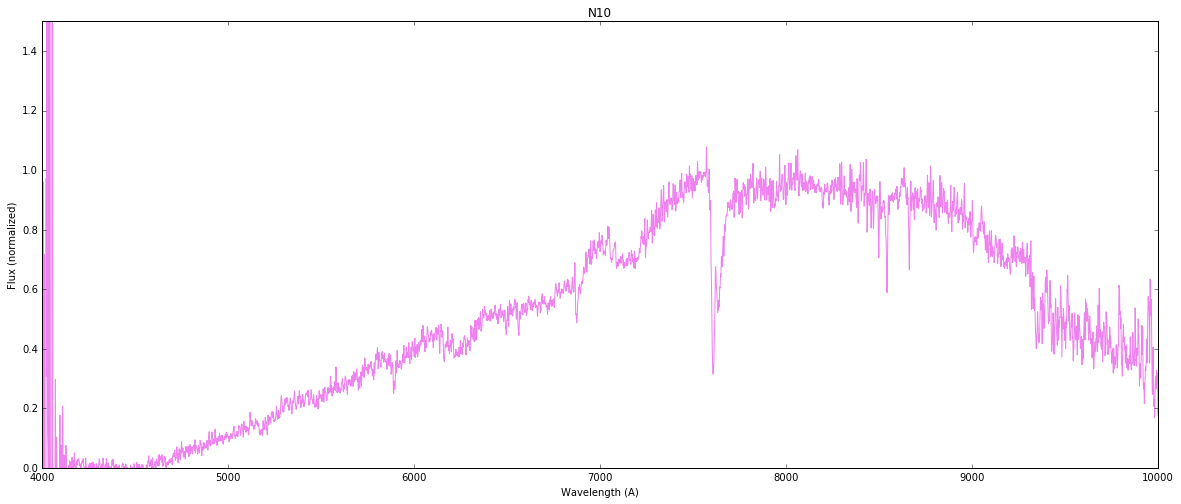

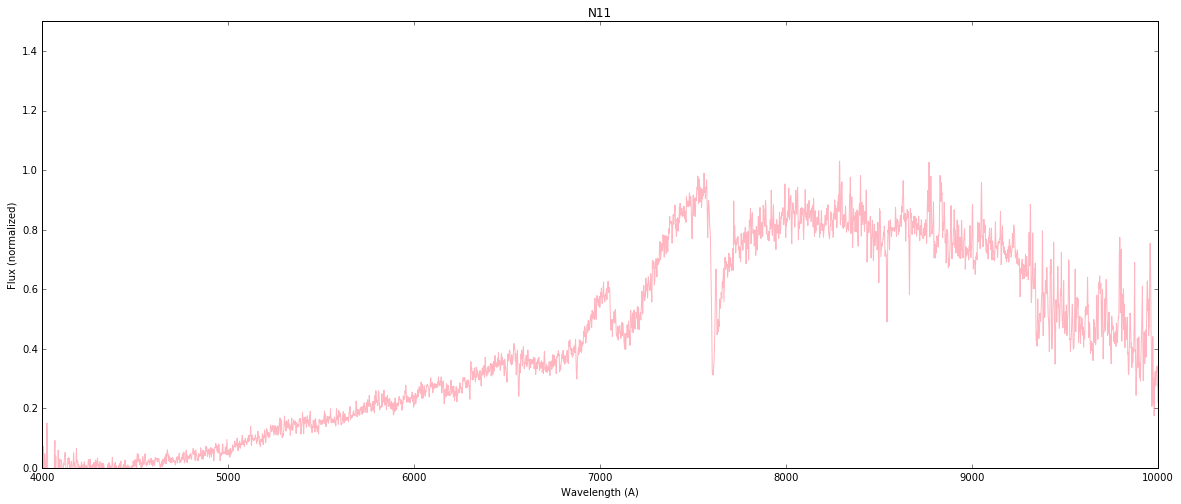

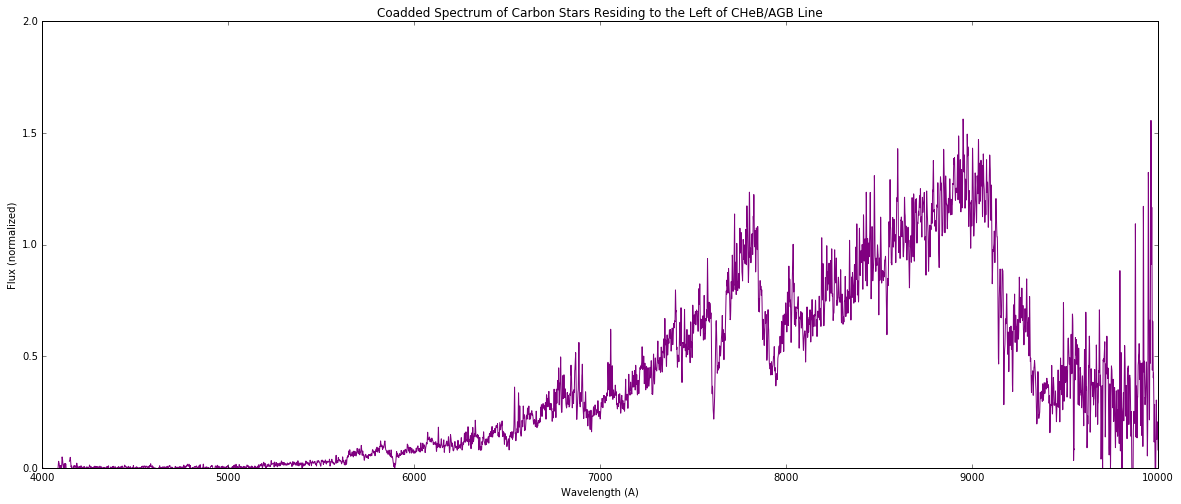

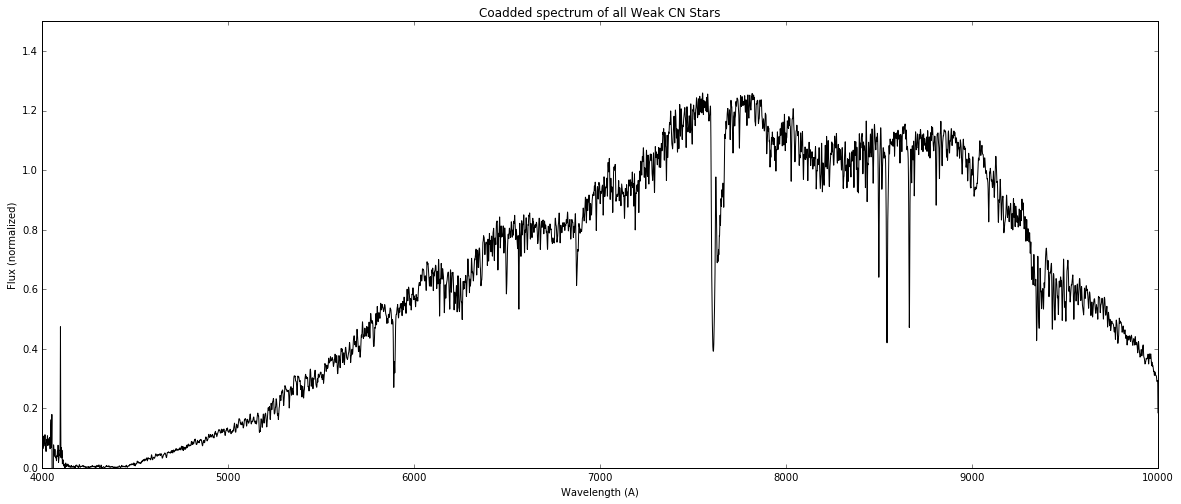

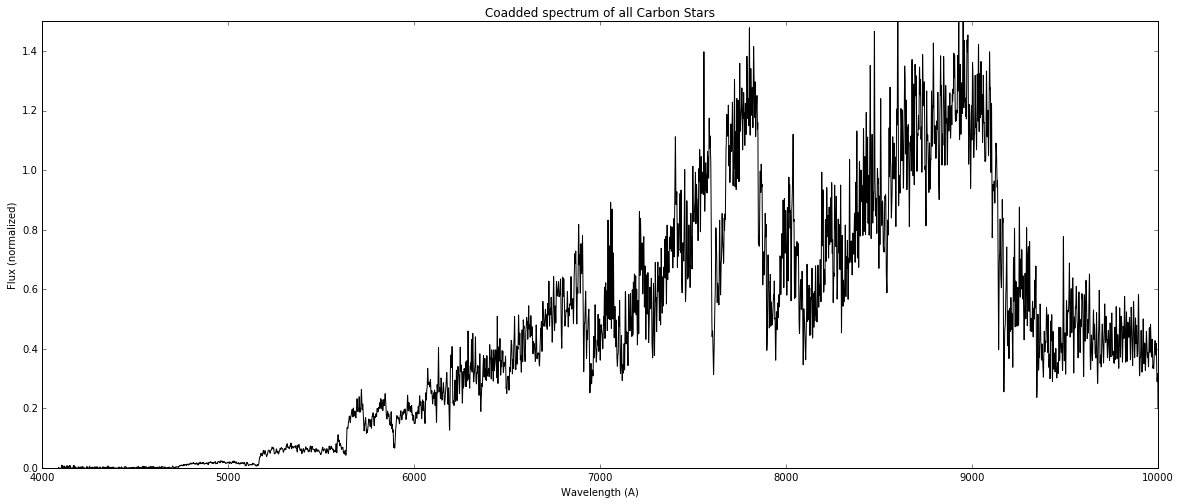

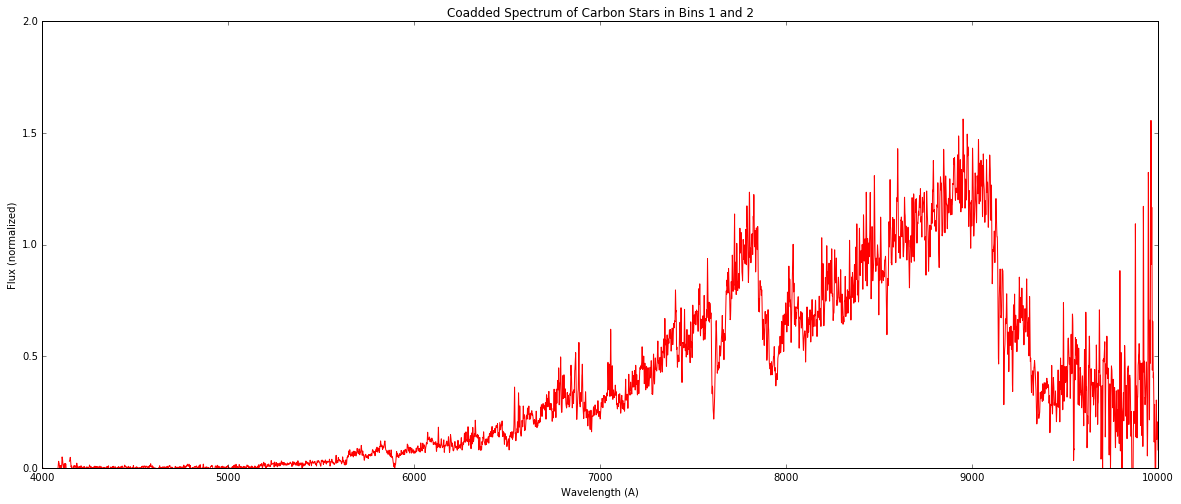

In [94]:
py.rcParams['figure.figsize'] = 20, 8

# Coadd of non-carbon stars in bin #1
py.figure(1)
py.plot(wv, bin1CoaddSm, 'brown')
py.title('N1')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 3])

# Coadd of non-carbon stars in bin #2
py.figure(2)
py.plot(wv, bin2CoaddSm, 'red')
py.title('N2')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of carbon stars in bins 1 and 2
py.figure(20)
py.plot(wv, bin1_2C_CoaddSm, 'red')
py.title('Coadded Spectrum of Carbon Stars in Bins 1 and 2')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of non-carbon stars in bin #3
py.figure(3)
py.plot(wv, bin3CoaddSm, 'darkorange')
py.title('N3')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of carbon stars in bin #3
py.figure(4)
py.plot(wv, bin3C_CoaddSm, 'darkorange')
py.title('C3')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of non-carbon stars in bin #4
py.figure(5)
py.plot(wv, bin4CoaddSm, 'orange')
py.title('N4')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of non-carbon stars in bin #5
py.figure(6)
py.plot(wv, bin5CoaddSm, 'green')
py.title('N5')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of carbon stars in bin #5
py.figure(7)
py.plot(wv, bin5C_CoaddSm, 'green')
py.title('C5')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of non-carbon stars in bin #6
py.figure(8)
py.plot(wv, bin6Coadd, 'blue')
py.title('N6')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of non-carbon stars in bin #7
py.figure(9)
py.plot(wv, bin7CoaddSm, 'indigo')
py.title('N7')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of weak CN stars in bin #7
py.figure(10)
py.plot(wv, bin7wCNcoaddSm, 'indigo')
py.title('W7')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of non-carbon stars in bin #8
py.figure(11)
py.plot(wv, bin8CoaddSm, 'darkviolet')
py.title('N8')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of weak CN stars in bin #8
py.figure(12)
py.plot(wv, bin8wCNcoaddSm, 'darkviolet')
py.title('W8')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of non-carbon stars in bin #9
py.figure(13)
py.plot(wv, bin9CoaddSm, 'magenta')
py.title('N9')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of weak CN stars in bin #9
py.figure(14)
py.plot(wv, bin9wCNcoaddSm, 'magenta')
py.title('W9')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of non-carbon stars in bin #10
py.figure(15)
py.plot(wv, bin10CoaddSm, 'violet')
py.title('N10')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])


# Coadd of non-carbon stars in bin #11
py.figure(16)
py.plot(wv, bin11CoaddSm, 'lightpink')
py.title('N11')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of carbon stars to the left of CHeB/AGB line
py.figure(17)
py.plot(wv, bin1_2C_CoaddSm, 'purple')
py.title('Coadded Spectrum of Carbon Stars Residing to the Left of CHeB/AGB Line')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 2])

# Coadd of ALL weak CN stars
py.figure(18)
py.plot(wv, weakCNcoaddSm, 'black')
py.title('Coadded spectrum of all Weak CN Stars')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])

# Coadd of ALL weak CN stars
py.figure(19)
py.plot(wv, carbonCoaddSm, 'black')
py.title('Coadded spectrum of all Carbon Stars')
py.xlabel('Wavelength (A)')
py.ylabel('Flux (normalized)')
py.ylim([0, 1.5])




In [95]:
# Experiment based off of HeB paper. Plot CMD of V vs. V - I

# py.rcParams['figure.figsize'] = 16,16
# mm.cmd_plot3(ncData, range(len(ncData)), 1, 'k', label = 'Non-carbon stars') #NONCARBON stars are BLACK and smaller
# mm.cmd_plot3(exData, range(len(exData)), 30, 'r', label = 'Extreme carbon stars') #EXTREME carbon stars are RED
# mm.cmd_plot3(Cdata, range(len(Cdata)), 30, 'lime', label = 'Strong carbon stars') #STRONG carbon stars are LIME
# mm.cmd_plot3(mcData, range(len(mcData)), 30, 'darkorange', label = 'Medium carbon stars')#MEDIUM carbon stars are DARK ORANGE
# mm.cmd_plot3(wcData, range(len(wcData)), 30, 'b', label = 'Weak carbon stars') #WEAK carbon stars are BLUE
# mm.cmd_plot3(marData, range(len(marData)), 30, 'm', label = 'Marginal carbon stars') #MARGINAL carbon stars are MAGENTA 
# py.xlim([-2, 10])
# py.ylim([32, 15])

[]

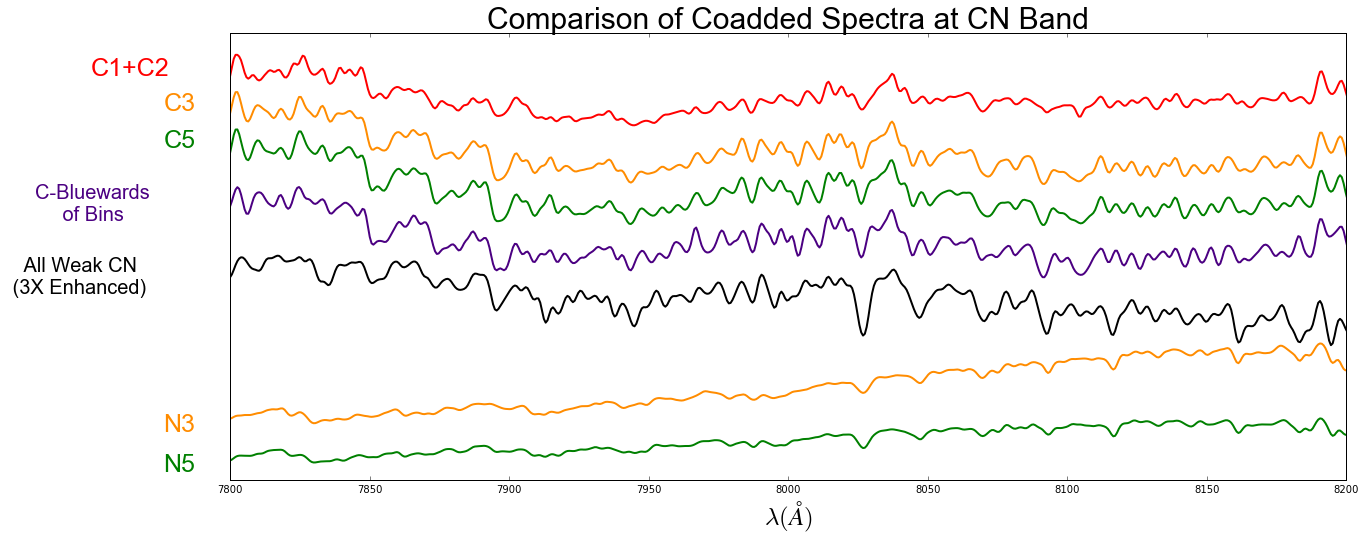

In [96]:
# Plot comparing spectral features of weak CN, carbon, and normal stars at 7800-8200 Angstroms
font = {'fontname': 'Arial'}
py.figure(18)
py.rcParams['figure.figsize'] = 16*.8, 8*.8
py.plot(wv, bin1_2C_CoaddSm + 4, 'red', linewidth = 2)
py.plot(wv, bin3C_CoaddSm + 3.3, 'darkorange', linewidth = 2)
py.plot(wv, bin5C_CoaddSm + 2.8, 'green', linewidth = 2)
py.plot(wv, binLeftC_CoaddSm + 2.2, 'indigo', linewidth = 2)
py.plot(wv, weakCNcoaddSmX + .9, 'black' , linewidth = 2)
py.plot(wv, bin3CoaddSm, 'darkorange' , linewidth = 2)
py.plot(wv, bin5CoaddSm - .6, 'green', linewidth = 2)

py.text(7750, 4.99, 'C1+C2', color = 'red', fontsize = 25, **font)
py.text(7776, 4.55, 'C3', color = 'darkorange', fontsize = 25, **font)
py.text(7776, 4.1, 'C5', color = 'green', fontsize = 25, **font)
py.text(7730, 3.2, 'C-Bluewards\n     of Bins', color = 'indigo', fontsize = 20, **font)

py.text(7720, 2.3, '   All Weak CN\n (3X Enhanced)', color = 'black', fontsize = 20, **font)

py.text(7776, .6, 'N3', color = 'darkorange', fontsize = 25, **font)
py.text(7776, .1, 'N5', color = 'green', fontsize = 25, **font)


py.title('Comparison of Coadded Spectra at CN Band', fontsize = 30, **font)
py.xlabel(r'$\lambda (\AA)$', fontsize = 25, **font)
py.xlim([7800, 8200])
py.ylim([0, 5.5])

frame = py.gca()
frame.axes.get_yaxis().set_ticks([])

In [97]:
# extracting, normalizing, and smoothing weak CN selection for poster introduction

wCNselectData = wcData[[6, 7, 20, 33, 34, 35, 39]]
wCNselectS_N = wCNselectData['ZSNR']


# normalizing..
wCNselectFluxNor = []
wCNselectVarNor = []
for i in range(len(wCNselectData)):
    [fluxTemp, ivarTemp] = mm.normal(wCNselectData['SPEC'][i], wCNselectData['IVAR'][i])
    wCNselectFluxNor += [fluxTemp]
    wCNselectVarNor += [ivarTemp]
wCNselectFluxNor = np.array(wCNselectFluxNor)
wCNselectVarNor = np.array(wCNselectVarNor)

# Smoothing...note, final product will be an array containing all select weak CN star's normalized and smoothed spectra
# Also not...normalizing wasn't necessary..feck!
wCNselectSmSpec = []
for i in range(len(wCNselectData)):
    wCNselectSmSpec += [convolve(wCNselectFluxNor[i], gauss)]
    
# Remove A-band...

for i in range(len(wCNselectData)):
    wCNselectSmSpec[i] = mm.removeTelluric(wCNselectSmSpec[i], wv)



In [98]:
# extracting, normalizing, and smoothing carbon star selection for poster introduction

CselectData = Cdata[[2, 3, 4, 5, 8, 7, 10, 9, 12, 13, 6, 11, 16, 17, 23]]
CselectS_N = CselectData['ZSNR']

# normalizing..
CselectFluxNor = []
CselectVarNor = []
for i in range(len(CselectData)):
    [fluxTemp, ivarTemp] = mm.normal(CselectData['SPEC'][i], CselectData['IVAR'][i])
    CselectFluxNor += [fluxTemp]
    CselectVarNor += [ivarTemp]
CselectFluxNor = np.array(CselectFluxNor)
CselectVarNor = np.array(CselectVarNor)

# Smoothing...note, final product will be an array containing all select weak CN star's normalized and smoothed spectra
# Also not...normalizing wasn't necessary..feck!
CselectSmSpec = []
for i in range(len(CselectData)):
    CselectSmSpec += [convolve(CselectFluxNor[i], gauss)]
    
# Remove A-band...

for i in range(len(CselectData)):
    CselectSmSpec[i] = mm.removeTelluric(CselectSmSpec[i], wv)

In [99]:
# This block will generate all plots for poster presentation


[]

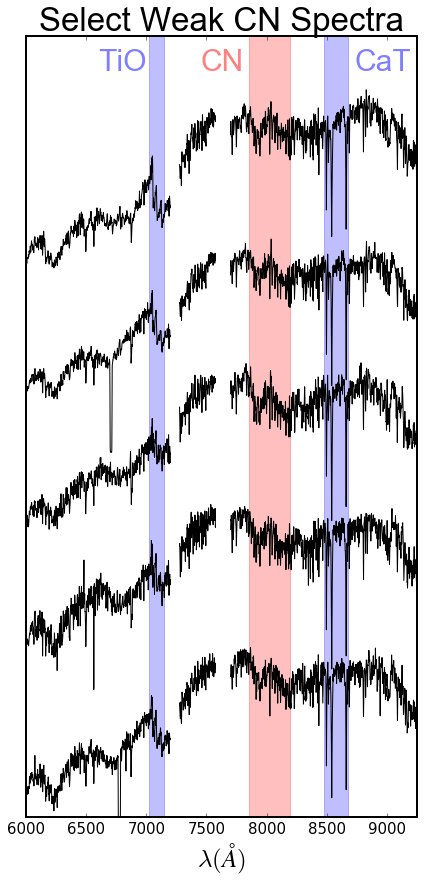

In [100]:
# Intro plot of select weak CN spectra

py.rcParams['figure.figsize'] = 7, 14
py.rc('xtick', labelsize = 15) 
py.rc('axes', linewidth = 2)
py.figure(1)
ax = py.plot(wv, wCNselectSmSpec[6] - .3, 'black')
py.plot(wv, wCNselectSmSpec[0] + .5, 'black')
py.plot(wv, wCNselectSmSpec[3] + 1.3, 'black')
py.plot(wv, wCNselectSmSpec[4] + 2.1, 'black')
py.plot(wv, wCNselectSmSpec[5] + 2.9, 'black')
py.fill_between(range(7850, 8200), 0, 7, color = 'red', alpha=0.25, label = 'CN')
py.fill_between(range(7025, 7150), 0, 7, color = 'blue', alpha=0.25, label = 'TiO')
py.fill_between(range(8480, 8680), 0, 7, color = 'blue', alpha=0.25, label = 'CaT')

font = {'fontname':'Arial'}
py.text(7450, 4.3, 'CN', color = 'red', alpha = 0.5, fontsize = 30, **font)
py.text(6600, 4.3, 'TiO', color = 'blue', alpha = 0.5, fontsize = 30, **font)
py.text(8730, 4.3, 'CaT', color = 'blue', alpha = 0.5, fontsize = 30, **font)
py.title('Select Weak CN Spectra', size = 33, **font)
py.xlabel(r'$\lambda (\AA)$', fontsize = 25, **font)
py.xlim([6000, 9250])
py.ylim([0, 4.5])
frame = py.gca()
frame.axes.get_yaxis().set_ticks([])






[]

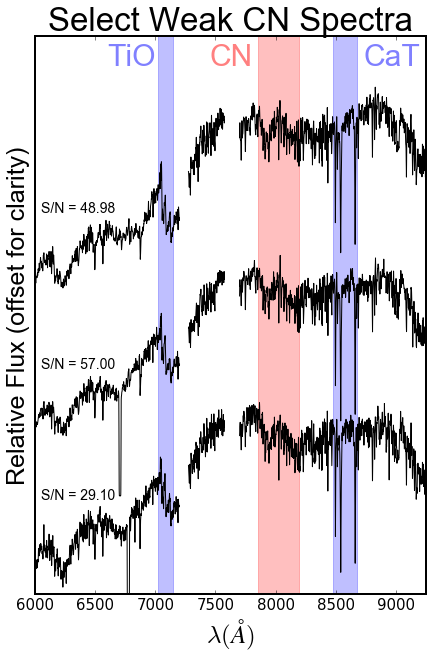

In [101]:
# Intro plot of select weak CN spectra (3-only)

py.rcParams['figure.figsize'] = 7, 10
py.rc('xtick', labelsize = 15) 
py.rc('axes', linewidth = 2)
py.figure(1)
ax = py.plot(wv, wCNselectSmSpec[6] - .3, 'black')
# py.plot(wv, wCNselectSmSpec[0] + .5, 'black')
# py.plot(wv, wCNselectSmSpec[3] + 1.3, 'black')
py.plot(wv, wCNselectSmSpec[4] + .5, 'black')
py.plot(wv, wCNselectSmSpec[5] + 1.3, 'black')
py.fill_between(range(7850, 8200), 0, 7, color = 'red', alpha=0.25, label = 'CN')
py.fill_between(range(7025, 7150), 0, 7, color = 'blue', alpha=0.25, label = 'TiO')
py.fill_between(range(8480, 8680), 0, 7, color = 'blue', alpha=0.25, label = 'CaT')

font = {'fontname':'Arial'}
py.text(7450, 2.7, 'CN', color = 'red', alpha = 0.5, fontsize = 30, **font)
py.text(6600, 2.7, 'TiO', color = 'blue', alpha = 0.5, fontsize = 30, **font)
py.text(8730, 2.7, 'CaT', color = 'blue', alpha = 0.5, fontsize = 30, **font)

py.text(6050, 1.95, 'S/N = ' + "{:.2f}".format(wCNselectS_N[5]) , color = 'black', fontsize = 14, **font)
py.text(6050, 1.15, 'S/N = ' + "{:.2f}".format(wCNselectS_N[4]) , color = 'black', fontsize = 14, **font)
py.text(6050, .48, 'S/N = ' + "{:.2f}".format(wCNselectS_N[6]) , color = 'black', fontsize = 14, **font)


py.title('Select Weak CN Spectra', size = 33, **font)
py.xlabel(r'$\lambda (\AA)$', fontsize = 25, **font)
py.ylabel('Relative Flux (offset for clarity)', fontsize = 25, **font)
py.xlim([6000, 9250])
py.ylim([0, 2.85])
frame = py.gca()
frame.axes.get_yaxis().set_ticks([])


[]

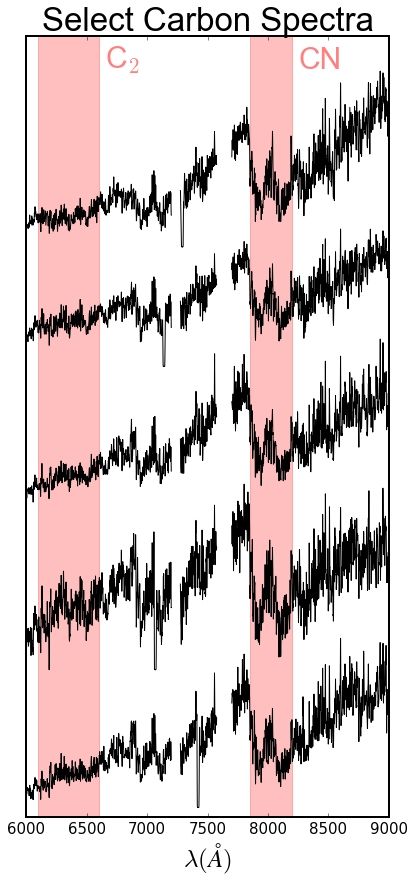

In [102]:

# Intro plot of select carbon spectra

py.rcParams['figure.figsize'] = 6.5, 14
py.rc('xtick', labelsize = 15) 
py.rc('axes', linewidth = 2)
py.figure(1)
py.plot(wv, CselectSmSpec[1] + .1, 'black')
py.plot(wv, CselectSmSpec[3] + 1.6, 'black')
py.plot(wv, CselectSmSpec[4] + 3.3, 'black')
py.plot(wv, CselectSmSpec[13] + 4.9, 'black')
py.plot(wv, CselectSmSpec[12] + 6.2, 'black')
py.fill_between(range(7850, 8200), 0, 30, color = 'red', alpha=0.25, label = 'CN')
py.fill_between(range(6100, 6600), 0, 30, color = 'red', alpha=0.25, label = 'C2')
font = {'fontname':'Arial'}
py.text(8250, 8.15, 'CN', color = 'red', alpha = 0.5, fontsize = 30, **font)
py.text(6650, 8.15, 'C' + r'$_2$', color = 'red', alpha = 0.5, fontsize = 30, **font)
py.title('Select Carbon Spectra', size = 33, **font)
py.xlabel(r'$\lambda (\AA)$', fontsize = 25, **font)
py.xlim([6000, 9000])
py.ylim([0, 8.5])
frame = py.gca()
frame.axes.get_yaxis().set_ticks([])


[]

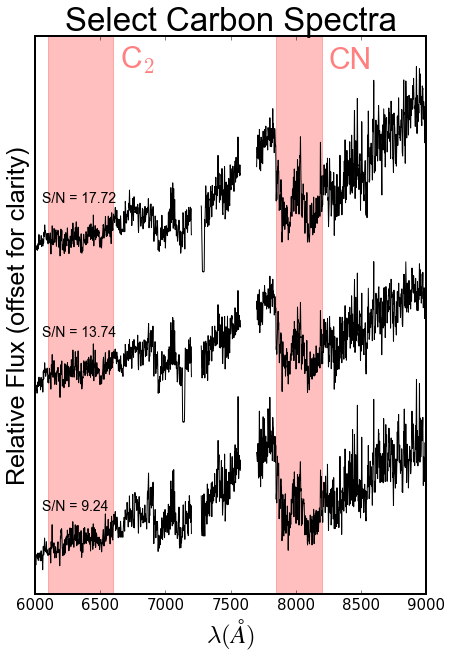

In [103]:
# Intro plot of select carbon spectra (3 specs)

py.rcParams['figure.figsize'] = 7, 10
py.rc('xtick', labelsize = 15) 
py.rc('axes', linewidth = 2)
py.figure(1)
# py.plot(wv, CselectSmSpec[1] + .1, 'black')
# py.plot(wv, CselectSmSpec[3] + 1.6, 'black')
py.plot(wv, CselectSmSpec[4] + .1, 'black')
py.plot(wv, CselectSmSpec[13] + 1.6, 'black')
py.plot(wv, CselectSmSpec[12] + 3., 'black')
py.fill_between(range(7850, 8200), 0, 30, color = 'red', alpha=0.25, label = 'CN')
py.fill_between(range(6100, 6600), 0, 30, color = 'red', alpha=0.25, label = 'C2')
font = {'fontname':'Arial'}
py.text(8250, 4.9, 'CN', color = 'red', alpha = 0.5, fontsize = 30, **font)
py.text(6650, 4.9, 'C' + r'$_2$', color = 'red', alpha = 0.5, fontsize = 30, **font)

py.text(6050, 3.65, 'S/N = ' + "{:.2f}".format(CselectS_N[12]) , color = 'black', fontsize = 14, **font)
py.text(6050, 2.4, 'S/N = ' + "{:.2f}".format(CselectS_N[13]) , color = 'black', fontsize = 14, **font)
py.text(6050, .78, 'S/N = ' + "{:.2f}".format(CselectS_N[14]) , color = 'black', fontsize = 14, **font)



py.title('Select Carbon Spectra', size = 33, **font)
py.xlabel(r'$\lambda (\AA)$', fontsize = 25, **font)
py.ylabel('Relative Flux (offset for clarity)', fontsize = 25, **font)
py.xlim([6000, 9000])
py.ylim([0, 5.2])
frame = py.gca()
frame.axes.get_yaxis().set_ticks([])

[]

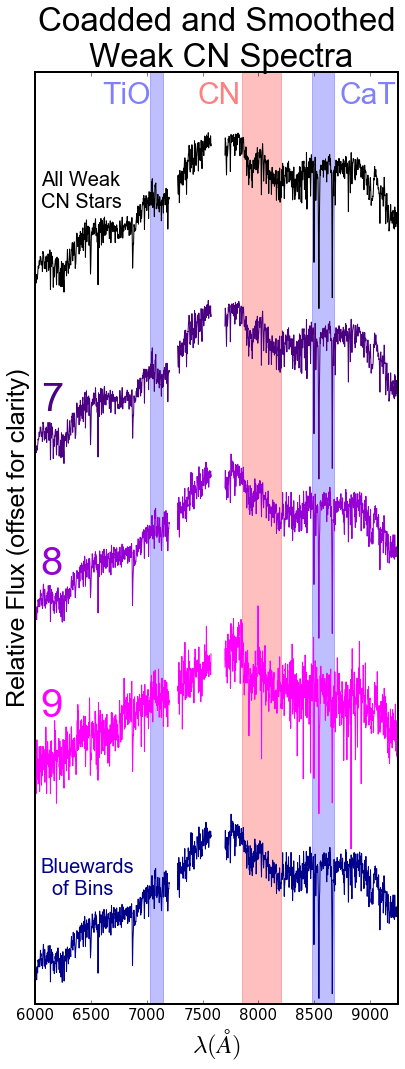

In [104]:
# ladder  of coadded Weak CN spectra

# Remove A-band...

bin7wCNcoaddSmClip = mm.removeTelluric(bin7wCNcoaddSm, wv)
bin8wCNcoaddSmClip = mm.removeTelluric(bin8wCNcoaddSm, wv)
bin9wCNcoaddSmClip = mm.removeTelluric(bin9wCNcoaddSm, wv)
binLeftwCNcoaddSmClip = mm.removeTelluric(binLeftwCNcoaddSm, wv)
weakCNcoaddSmClip = mm.removeTelluric(weakCNcoaddSm, wv)


py.rcParams['figure.figsize'] = 6.5, 16.7
py.rc('xtick', labelsize = 15) 
py.rc('axes', linewidth = 2)
py.figure(1)
py.plot(wv, bin8wCNcoaddSmClip - .42, 'darkblue')
ax = py.plot(wv, bin9wCNcoaddSmClip + .5, 'magenta')
py.plot(wv, bin8wCNcoaddSmClip + 1.3, 'darkviolet')
py.plot(wv, bin7wCNcoaddSmClip + 2.1, 'indigo')
py.plot(wv, weakCNcoaddSmClip + 2.9, 'black')
py.fill_between(range(7850, 8200), 0, 7, color = 'red', alpha=0.25, label = 'CN')
py.fill_between(range(7025, 7150), 0, 7, color = 'blue', alpha=0.25, label = 'TiO')
py.fill_between(range(8480, 8680), 0, 7, color = 'blue', alpha=0.25, label = 'CaT')

font = {'fontname':'Arial'}
py.text(7450, 4.3, 'CN', color = 'red', alpha = 0.5, fontsize = 30, **font)
py.text(6600, 4.3, 'TiO', color = 'blue', alpha = 0.5, fontsize = 30, **font)
py.text(8730, 4.3, 'CaT', color = 'blue', alpha = 0.5, fontsize = 30, **font)

py.text(6050, 3.8, 'All Weak\nCN Stars', color = 'black', fontsize = 20, **font)
py.text(6050, 2.83, '7', color = 'indigo', fontsize = 40, **font)
py.text(6050, 2.05, '8', color = 'darkviolet', fontsize = 40, **font)
py.text(6050, 1.37, '9', color = 'magenta', fontsize = 40, **font)
py.text(6050, .52, 'Bluewards\n  of Bins', color = 'darkblue', fontsize = 20, **font)



py.title('Coadded and Smoothed\n Weak CN Spectra', size = 33, **font)
py.xlabel(r'$\lambda (\AA)$', fontsize = 25, **font)
py.ylabel('Relative Flux (offset for clarity)', fontsize = 25, **font)
py.xlim([6000, 9250])
py.ylim([0, 4.45])
frame = py.gca()
frame.axes.get_yaxis().set_ticks([])


[]

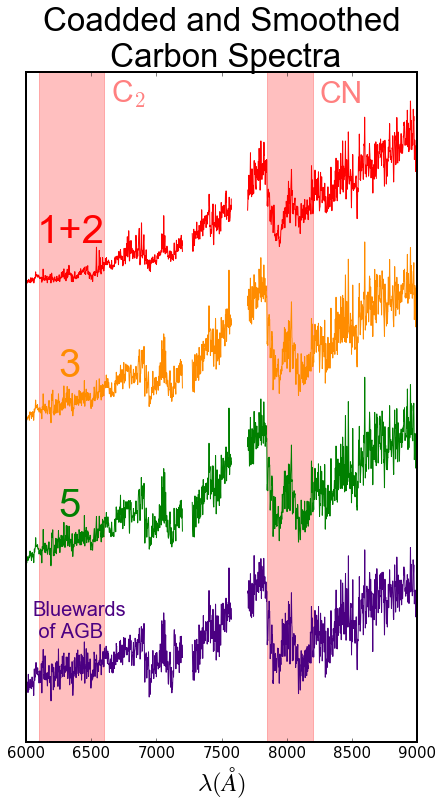

In [105]:

# Ladder plot of carbon star coadds

bin1_2C_CoaddSmClip = mm.removeTelluric(bin1_2C_CoaddSm, wv)
bin3C_CoaddSmClip = mm.removeTelluric(bin3C_CoaddSm, wv)
bin5C_CoaddSmClip = mm.removeTelluric(bin5C_CoaddSm, wv)
binLeftC_CoaddSmClip = mm.removeTelluric(binLeftC_CoaddSm, wv)




py.rcParams['figure.figsize'] = 7, 12
py.rc('xtick', labelsize = 15) 
py.rc('axes', linewidth = 2)
py.figure(1)
py.plot(wv, binLeftC_CoaddSmClip + .1, 'indigo')
py.plot(wv, bin5C_CoaddSmClip + 1.3, 'green')
py.plot(wv, bin3C_CoaddSmClip + 2.5, 'darkorange')
py.plot(wv, bin1_2C_CoaddSmClip + 3.7, 'red')
py.fill_between(range(7850, 8200), 0, 30, color = 'red', alpha=0.25, label = 'CN')
py.fill_between(range(6100, 6600), 0, 30, color = 'red', alpha=0.25, label = 'C2')

font = {'fontname':'Arial'}
py.text(8250, 5.25, 'CN', color = 'red', alpha = 0.5, fontsize = 30, **font)
py.text(6650, 5.25, 'C' + r'$_2$', color = 'red', alpha = 0.5, fontsize = 30, **font)

py.text(6080, 4.1, '1+2', color = 'red', fontsize = 40, **font)
py.text(6250, 3., '3', color = 'darkorange', fontsize = 40, **font)
py.text(6250, 1.85, '5', color = 'green', fontsize = 40, **font)
py.text(6050, .85, 'Bluewards\n of AGB', color = 'indigo', fontsize = 20, **font)


py.title('Coadded and Smoothed\n Carbon Spectra', size = 33, **font)
py.xlabel(r'$\lambda (\AA)$', fontsize = 25, **font)
py.xlim([6000, 9000])
py.ylim([0, 5.5])
frame = py.gca()
frame.axes.get_yaxis().set_ticks([])



[]

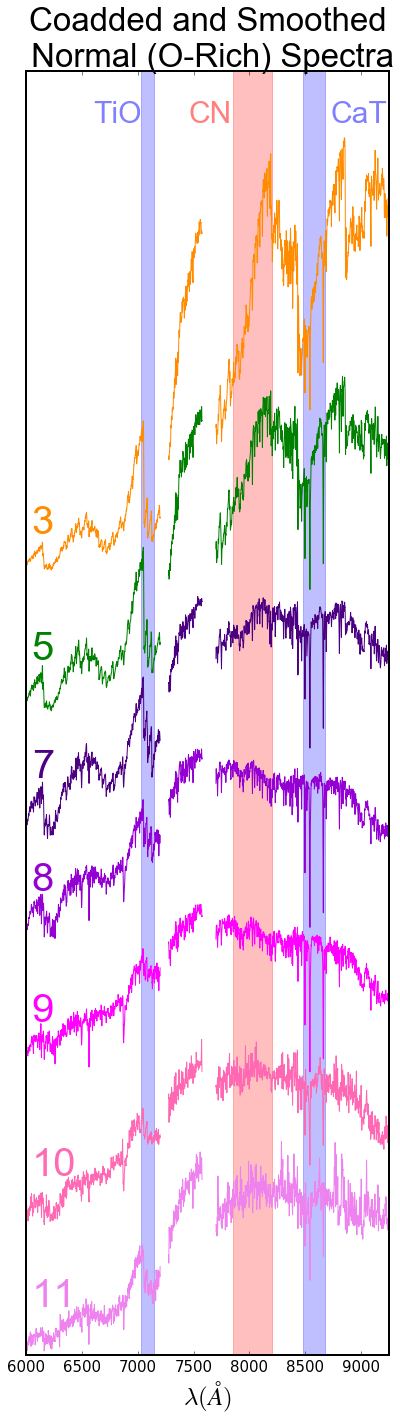

In [106]:
# ladder plot for normal coadds

# remove A and B bands 
bin1CoaddSmClip = mm.removeTelluric(bin1CoaddSm, wv)
bin2CoaddSmClip = mm.removeTelluric(bin2CoaddSm, wv)
bin3CoaddSmClip = mm.removeTelluric(bin3CoaddSm, wv)
bin4CoaddSmClip = mm.removeTelluric(bin4CoaddSm, wv)
bin5CoaddSmClip = mm.removeTelluric(bin5CoaddSm, wv)
bin6CoaddSmClip = mm.removeTelluric(bin6CoaddSm, wv)
bin7CoaddSmClip = mm.removeTelluric(bin7CoaddSm, wv)
bin8CoaddSmClip = mm.removeTelluric(bin8CoaddSm, wv)
bin9CoaddSmClip = mm.removeTelluric(bin9CoaddSm, wv)
bin10CoaddSmClip = mm.removeTelluric(bin10CoaddSm, wv)
bin11CoaddSmClip = mm.removeTelluric(bin11CoaddSm, wv)
normCoaddSmClip = mm.removeTelluric(normCoaddSm, wv)



py.rcParams['figure.figsize'] = 6.5, 23
py.rc('xtick', labelsize = 15) 
py.rc('axes', linewidth = 2)
py.figure(1)
ax = py.plot(wv, bin11CoaddSmClip - .2, 'violet')
py.plot(wv, bin10CoaddSmClip + .15, 'hotpink')
py.plot(wv, bin9CoaddSmClip + .63, 'magenta')
py.plot(wv, bin8CoaddSmClip + 1.21, 'darkviolet')
py.plot(wv, bin7CoaddSmClip + 1.8, 'indigo')
# py.plot(wv, bin6CoaddSmClip + 1.6, 'black')
py.plot(wv, bin5CoaddSmClip + 2.4, 'green')
# py.plot(wv, bin4CoaddSmClip + 2.3, 'black')
py.plot(wv, bin3CoaddSmClip + 3.0, 'darkorange')
# py.plot(wv, bin2CoaddSmClip + .5, 'black')
# py.plot(wv, bin1CoaddSmClip + .5, 'black')

py.fill_between(range(7025, 7150), 0, 7, color = 'blue', alpha=0.25, label = 'TiO')
py.fill_between(range(7850, 8200), 0, 30, color = 'red', alpha=0.25, label = 'CN')
py.fill_between(range(8480, 8680), 0, 7, color = 'blue', alpha=0.25, label = 'CaT')

py.text(6050, 1.81, '8', color = 'darkviolet', fontsize = 40, **font)
py.text(6050, 3.2, '3', color = 'darkorange', fontsize = 40, **font)
py.text(6050, 2.71, '5', color = 'green', fontsize = 40, **font)
py.text(6050, 2.25, '7', color = 'indigo', fontsize = 40, **font)
py.text(6050, 1.3, '9', color = 'magenta', fontsize = 40, **font)
py.text(6050, .7, '10', color = 'hotpink', fontsize = 40, **font)
py.text(6050, .19, '11', color = 'violet', fontsize = 40, **font)


font = {'fontname':'Arial'}
py.text(7450, 4.8, 'CN', color = 'red', alpha = 0.5, fontsize = 30, **font)
py.text(6600, 4.8, 'TiO', color = 'blue', alpha = 0.5, fontsize = 30, **font)
py.text(8730, 4.8, 'CaT', color = 'blue', alpha = 0.5, fontsize = 30, **font)
py.title('Coadded and Smoothed\n Normal (O-Rich) Spectra', size = 33, **font)
py.xlabel(r'$\lambda (\AA)$', fontsize = 25, **font)
py.xlim([6000, 9250])
py.ylim([0, 5])
frame = py.gca()
frame.axes.get_yaxis().set_ticks([])





[]

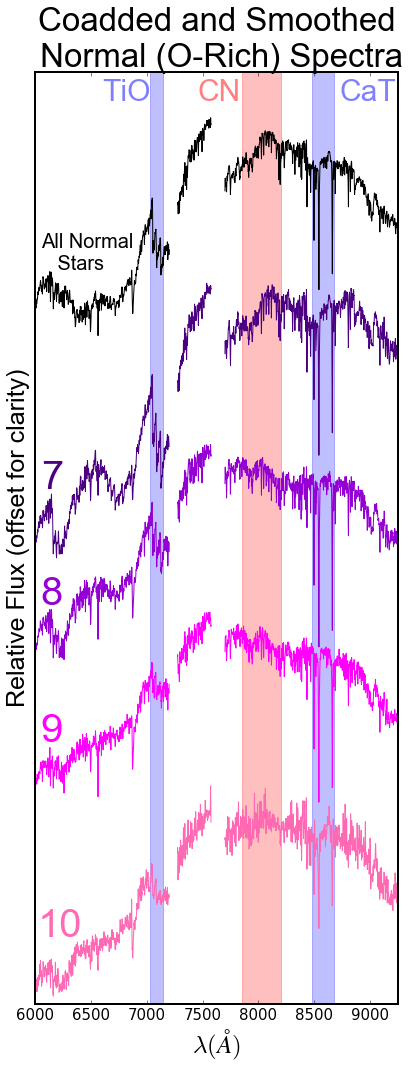

In [107]:
# Another ladder plot for normal coadds

py.rcParams['figure.figsize'] = 6.5, 16.7
py.rc('xtick', labelsize = 15) 
py.rc('axes', linewidth = 2)
py.figure(1)
py.plot(wv, bin10CoaddSmClip - .33, 'hotpink')
py.plot(wv, bin9CoaddSmClip + .22, 'magenta')
py.plot(wv, bin8CoaddSmClip + .77, 'darkviolet')
py.plot(wv, bin7CoaddSmClip + 1.32, 'indigo')
py.plot(wv, normCoaddSmClip + 1.87, 'black')


py.fill_between(range(7025, 7150), 0, 7, color = 'blue', alpha=0.25, label = 'TiO')
py.fill_between(range(7850, 8200), 0, 30, color = 'red', alpha=0.25, label = 'CN')
py.fill_between(range(8480, 8680), 0, 7, color = 'blue', alpha=0.25, label = 'CaT')

py.text(6050, 1.37, '8', color = 'darkviolet', fontsize = 40, **font)
py.text(6050, 2.52, 'All Normal\n   Stars', color = 'black', fontsize = 20, **font)
py.text(6050, 1.77, '7', color = 'indigo', fontsize = 40, **font)
py.text(6050, .9, '9', color = 'magenta', fontsize = 40, **font)
py.text(6020, .23, '10', color = 'hotpink', fontsize = 40, **font)


font = {'fontname':'Arial'}
py.text(7450, 3.1, 'CN', color = 'red', alpha = 0.5, fontsize = 30, **font)
py.text(6600, 3.1, 'TiO', color = 'blue', alpha = 0.5, fontsize = 30, **font)
py.text(8730, 3.1, 'CaT', color = 'blue', alpha = 0.5, fontsize = 30, **font)
py.title('Coadded and Smoothed\n Normal (O-Rich) Spectra', size = 33, **font)
py.xlabel(r'$\lambda (\AA)$', fontsize = 25, **font)
py.ylabel('Relative Flux (offset for clarity)', fontsize = 25, **font)
py.xlim([6000, 9250])
py.ylim([0, 3.2])
frame = py.gca()
frame.axes.get_yaxis().set_ticks([])

# py.plot(wv, bin8wCNcoaddSmClip - .42, 'darkblue')
# ax = py.plot(wv, bin9wCNcoaddSmClip + .5, 'magenta')
# py.plot(wv, bin8wCNcoaddSmClip + 1.3, 'darkviolet')
# py.plot(wv, bin7wCNcoaddSmClip + 2.1, 'indigo')
# py.plot(wv, weakCNcoaddSmClip + 2.9, 'black')

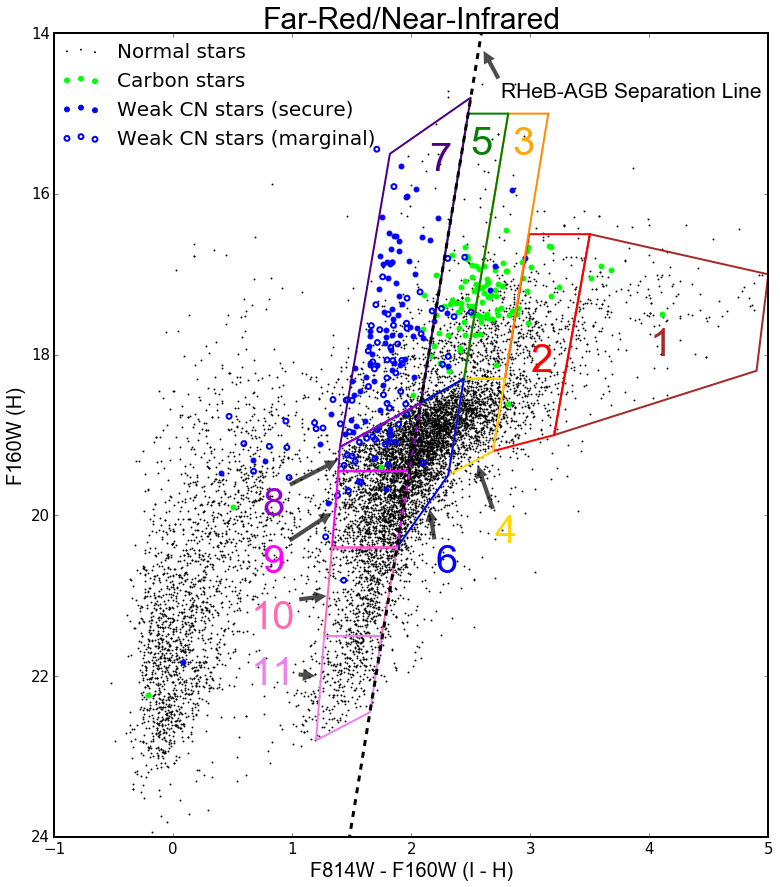

In [108]:
# H vs. I - H CMD for poster

py.rcParams['figure.figsize'] = 16*.8,18*.8
py.rc('xtick', labelsize = 15) 
py.rc('ytick', labelsize = 15) 
py.rc('axes', linewidth = 2)
mm.cmd_plot2(ncData, range(len(ncData)), 1*.8, 'k', label = 'Normal stars') #NONCARBON stars are BLACK and smaller
mm.cmd_plot2(Cdata, range(len(Cdata)), 30*.8, 'lime', label = 'Carbon stars') #carbon stars are LIME
mm.cmd_plot2(wcData, range(len(wcData)), 30*.8, 'b', label = 'Weak CN stars (secure)') #WEAK carbon stars are BLUE
py.scatter(marData.F814W[range(len(marData))] - marData.F160W[range(len(marData))], marData.F160W[range(len(marData))], s=30*.8, linewidth = 2, edgecolors = 'b', facecolors = 'none', label = 'Weak CN stars (marginal)') #MARGINAL carbon stars are open blue 

py.plot(xPhil, yPhil, color = 'k', linewidth = 3, linestyle = '--')

bin1 = py.Polygon([[3.2, 19.], [3.50, 16.5], [4.999, 17], [4.9, 18.2]], color = 'brown', fill = False, linewidth = 2)
bin1path = Path([[3.2, 19.], [3.50, 16.5], [4.999, 17], [4.9, 18.2]])
py.gca().add_patch(bin1)

bin2 = py.Polygon([[2.99, 16.5], [2.685, 19.2], [3.2, 19.], [3.50, 16.5]], color = 'red', fill = False, linewidth = 2)
bin2path = Path([[2.99, 16.5], [2.685, 19.2], [3.2, 19.], [3.50, 16.5]])
py.gca().add_patch(bin2)
# mask = bin5.contains_point([1,0])

bin3 = py.Polygon([[2.814, 15], [3.1506, 15], [2.785, 18.3], [2.442, 18.3]], color = 'darkorange', fill = False, linewidth = 2)
bin3path = Path([[2.814, 15], [3.1506, 15], [2.785, 18.3], [2.442, 18.3]])
py.gca().add_patch(bin3)

bin4 = py.Polygon([[2.442, 18.3], [2.785, 18.3], [2.685, 19.2], [2.31, 19.5]], color = 'gold', fill = False, linewidth = 2)
bin4path = Path([[2.442, 18.3], [2.785, 18.3], [2.685, 19.2], [2.31, 19.5]])
py.gca().add_patch(bin4)

bin5 = py.Polygon([[2.477468, 15], [2.814, 15], [2.442, 18.3], [2.079, 18.6]], color = 'green', fill = False, linewidth = 2)
bin5path = Path([[2.477468, 15], [2.814, 15], [2.442, 18.3], [2.079, 18.6]])
py.gca().add_patch(bin5)

bin6 = py.Polygon([[2.079, 18.6], [2.442, 18.3], [2.31, 19.5], [1.8795, 20.4]], color = 'blue', fill = False, linewidth = 2)
bin6path = Path([[2.079, 18.6], [2.442, 18.3], [2.31, 19.5], [1.8795, 20.4]])
py.gca().add_patch(bin6)

bin7 = py.Polygon([[1.4,19.15],[2.079, 18.6],[2.4996,14.8],[1.82,15.5]], color = 'indigo', fill = False, linewidth = 2)
bin7path = Path([[1.4,19.15],[2.079, 18.6],[2.4996,14.8],[1.82,15.5]])
py.gca().add_patch(bin7)

bin8 = py.Polygon([[1.4,19.15],[2.079, 18.6],[1.985, 19.45],[1.387,19.45]], color = 'darkviolet', fill = False, linewidth = 2)
bin8path = Path([[1.4,19.15],[2.079, 18.6],[1.985, 19.45],[1.387,19.45]])
py.gca().add_patch(bin8)

bin9 = py.Polygon([[1.387,19.45],[1.985, 19.45],[1.8795, 20.4],[1.333, 20.4]], color = 'magenta', fill = False, linewidth = 2)
bin9path = Path([[1.387,19.45],[1.985, 19.45],[1.8795, 20.4],[1.333, 20.4]])
py.gca().add_patch(bin9)

bin10 = py.Polygon([[1.333, 20.4],[1.8795, 20.4],[1.75,21.5],[1.268,21.5]], color = 'hotpink', fill = False, linewidth = 2)
bin10path = Path([[1.333, 20.4],[1.8795, 20.4],[1.75,21.5],[1.268,21.5]])
py.gca().add_patch(bin10)

bin11 = py.Polygon([[1.268,21.5],[1.75,21.5],[1.6524,22.45],[1.2,22.8]], color = 'violet', fill = False, linewidth = 2)
bin11path = Path([[1.268,21.5],[1.75,21.5],[1.6524,22.45],[1.2,22.8]])
py.gca().add_patch(bin11)


py.text(4, 18, '1', color = 'brown', fontsize = 40, **font)
py.text(3, 18.2, '2', color = 'red', fontsize = 40, **font)
py.text(2.85, 15.5, '3', color = 'orange', fontsize = 40, **font)
py.text(2.5, 15.5, '5', color = 'green', fontsize = 40, **font)
py.text(2.15, 15.7, '7', color = 'indigo', fontsize = 40, **font)

py.annotate('4', (2.55, 19.35), xytext=(2.7,20.33), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'gold', fontsize = 40, **font)
py.annotate('6', (2.15, 19.9), xytext=(2.2,20.7), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'blue', fontsize = 40, **font)
py.annotate('8', (1.4, 19.3), xytext=(.75, 20), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'darkviolet', fontsize = 40, **font)
py.annotate('9', (1.35, 19.95), xytext=(.75, 20.7), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'magenta', fontsize = 40, **font)
py.annotate('10', (1.3, 21), xytext=(.65, 21.4), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'hotpink', fontsize = 40, **font)
py.annotate('11', (1.2, 22), xytext=(.65, 22.1), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'violet', fontsize = 40, **font)
py.annotate('RHeB-AGB Separation Line', (2.6, 14.2), xytext=(2.75, 14.8), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'black', fontsize = 21, **font)


# refPoint= py.scatter(2, 18.5, s=100, color = 'magenta')
# refPoint2= py.scatter(2.8455, 17.75, s=100, color = 'orange')


py.xlim(-1, 5)
py.ylim(24, 14)
py.title('Far-Red/Near-Infrared', size = 30, **font)
py.xlabel('F814W - F160W (I - H)', fontsize = 20, **font)
py.ylabel('F160W (H)', fontsize = 20, **font)
lg = py.legend(bbox_to_anchor=(.475, 1.012), fontsize = 20)
lg.get_frame().set_alpha(0)


In [109]:
# B vs. B - I CMD for poster

# py.rcParams['figure.figsize'] = 16,18
# py.rc('xtick', labelsize = 15) 
# py.rc('ytick', labelsize = 15) 
# py.rc('axes', linewidth = 2)
# mm.cmd_plot3(ncData, range(len(ncData)), 1, 'k', label = 'Normal stars') #NONCARBON stars are BLACK and smaller
# mm.cmd_plot3(Cdata, range(len(Cdata)), 30, 'lime', label = 'Carbon stars') #carbon stars are LIME
# mm.cmd_plot3(wcData, range(len(wcData)), 30, 'b', label = 'Weak CN stars (secure)') #WEAK carbon stars are BLUE
# py.scatter(marData.F475W[range(len(marData))] - marData.F814W[range(len(marData))], marData.F475W[range(len(marData))], s=30, linewidth = 2, edgecolors = 'b', facecolors = 'none', label = 'Weak CN stars (marginal)') #MARGINAL carbon stars are open blue 

# py.xlim(-2, 9)
# py.ylim(32, 14)
# py.title('B Vs. B - I', size = 33, **font)
# py.xlabel('F475W - F814W (B - I)', fontsize = 25, **font)
# py.ylabel('F475W (H)', fontsize = 25, **font)
# lg = py.legend(bbox_to_anchor=(.381, 1.0), fontsize = 20)
# lg.get_frame().set_alpha(0)

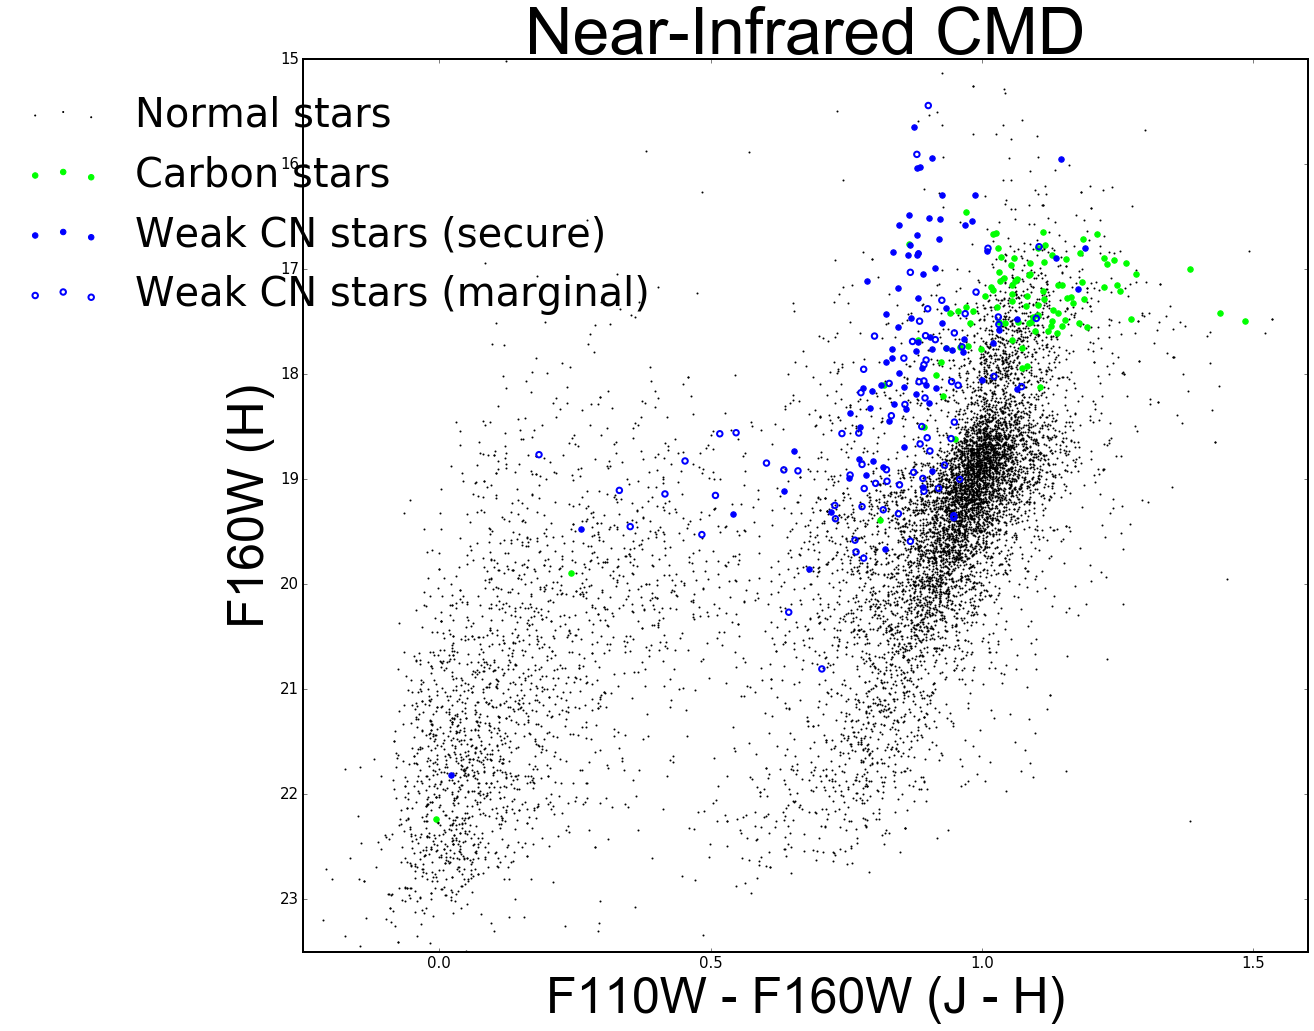

In [110]:
# H vs. J - H CMD for poster

py.rcParams['figure.figsize'] = 18, 16
py.rc('xtick', labelsize = 15) 
py.rc('ytick', labelsize = 15) 
py.rc('axes', linewidth = 2)
mm.cmd_plot4(ncData, range(len(ncData)), 1, 'k', label = 'Normal stars') #NONCARBON stars are BLACK and smaller
mm.cmd_plot4(Cdata, range(len(Cdata)), 30, 'lime', label = 'Carbon stars') #carbon stars are LIME
mm.cmd_plot4(wcData, range(len(wcData)), 30, 'b', label = 'Weak CN stars (secure)') #WEAK carbon stars are BLUE
py.scatter(marData.F110W[range(len(marData))] - marData.F160W[range(len(marData))], marData.F160W[range(len(marData))], s=30, linewidth = 2, edgecolors = 'b', facecolors = 'none', label = 'Weak CN stars (marginal)') #MARGINAL carbon stars are open blue 

py.xlim(-.25, 1.6)
py.ylim(23.5, 15)
py.title('Near-Infrared CMD', size = 66, **font)
py.xlabel('F110W - F160W (J - H)', fontsize = 50, **font)
py.ylabel('F160W (H)', fontsize = 50, **font)
lg = py.legend(bbox_to_anchor=(.381, 1.0), fontsize = 40)
lg.get_frame().set_alpha(0)

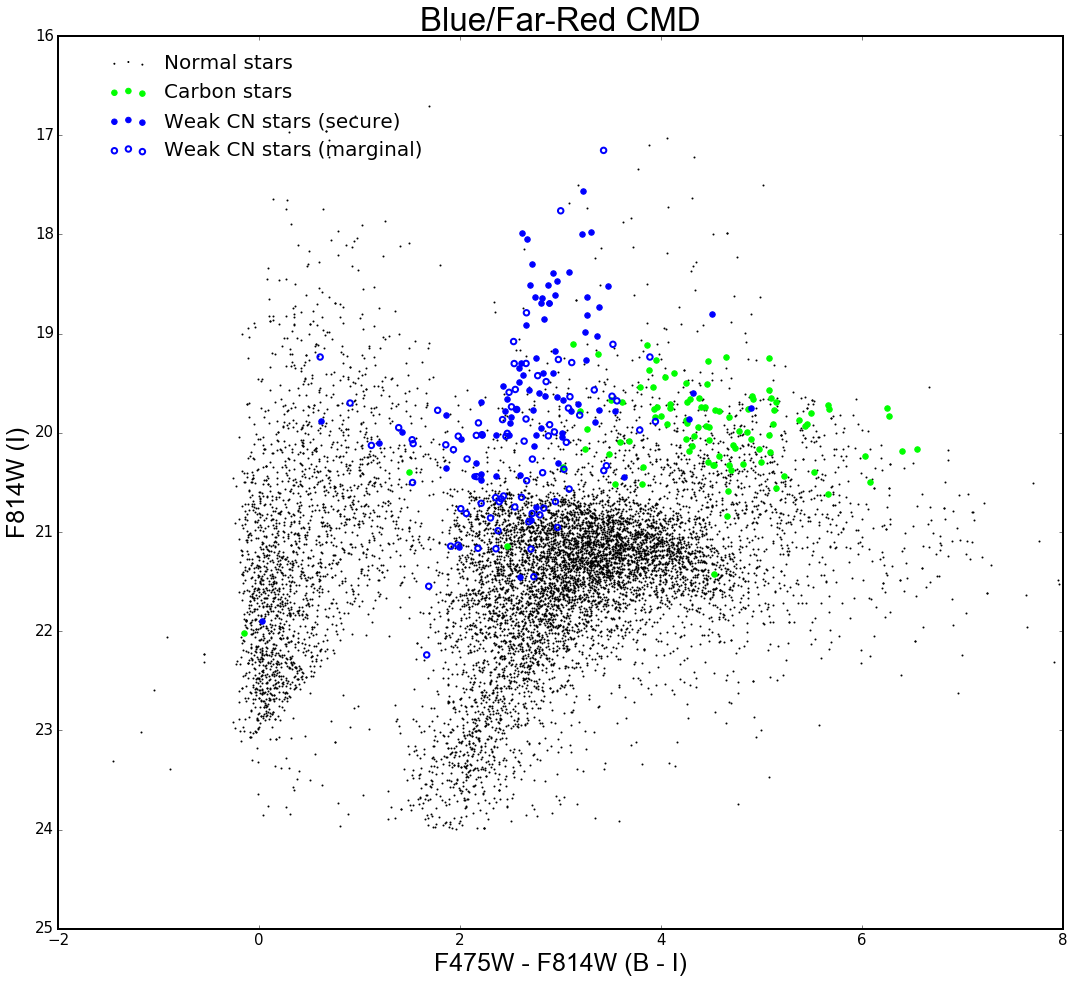

In [111]:
# I vs. B - I CMD for poster

py.rcParams['figure.figsize'] = 18,16
py.rc('xtick', labelsize = 15) 
py.rc('ytick', labelsize = 15) 
py.rc('axes', linewidth = 2)
mm.cmd_plot5(ncData, range(len(ncData)), 1, 'k', label = 'Normal stars') #NONCARBON stars are BLACK and smaller
mm.cmd_plot5(Cdata, range(len(Cdata)), 30, 'lime', label = 'Carbon stars') #carbon stars are LIME
mm.cmd_plot5(wcData, range(len(wcData)), 30, 'b', label = 'Weak CN stars (secure)') #WEAK carbon stars are BLUE
py.scatter(marData.F475W[range(len(marData))] - marData.F814W[range(len(marData))], marData.F814W[range(len(marData))], s=30, linewidth = 2, edgecolors = 'b', facecolors = 'none', label = 'Weak CN stars (marginal)') #MARGINAL carbon stars are open blue 

py.xlim(-2, 8)
py.ylim(25, 16)
py.title('Blue/Far-Red CMD', size = 33, **font)
py.xlabel('F475W - F814W (B - I)', fontsize = 25, **font)
py.ylabel('F814W (I)', fontsize = 25, **font)
lg = py.legend(bbox_to_anchor=(.381, 1.0), fontsize = 20)
lg.get_frame().set_alpha(0)

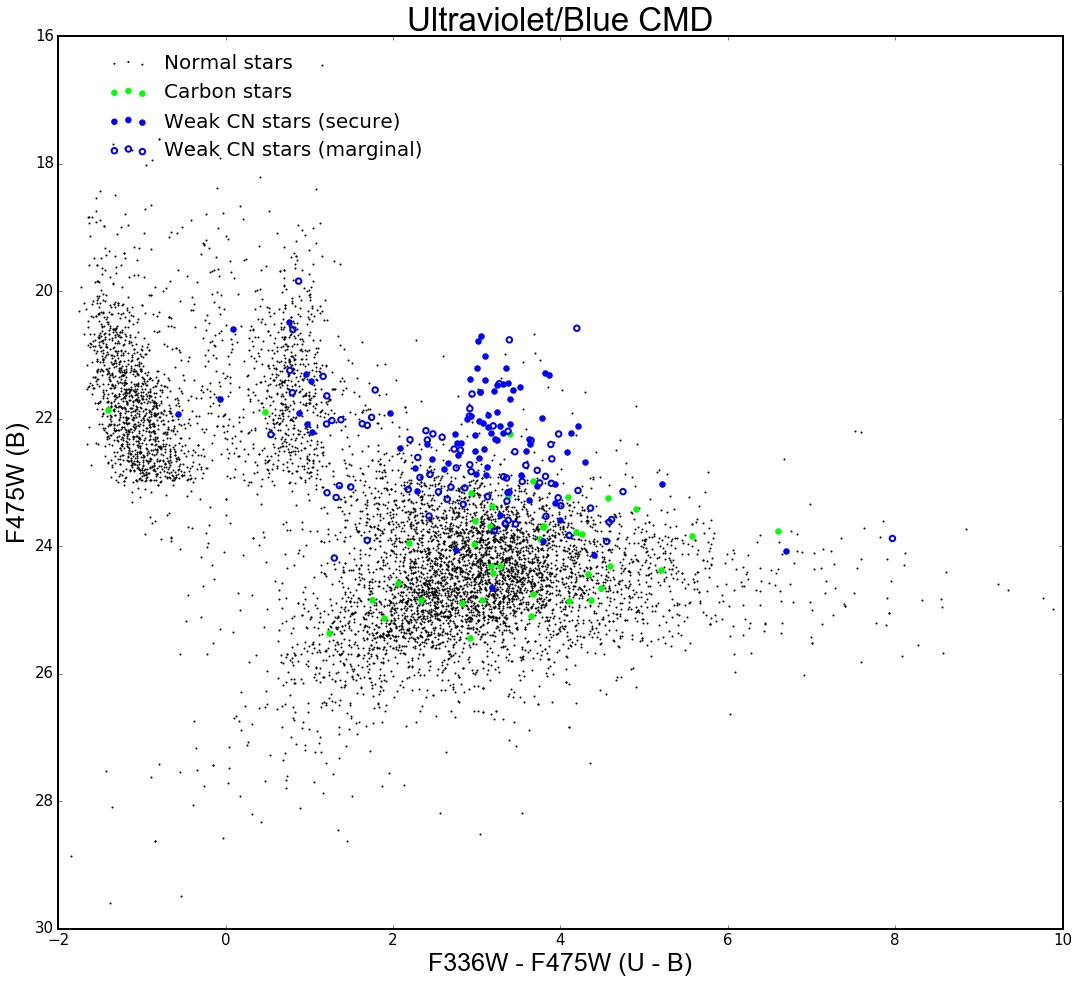

In [112]:
# B vs. U - B CMD for poster

py.rcParams['figure.figsize'] = 18,16
py.rc('xtick', labelsize = 15) 
py.rc('ytick', labelsize = 15) 
py.rc('axes', linewidth = 2)
mm.cmd_plot6(ncData, range(len(ncData)), 1, 'k', label = 'Normal stars') #NONCARBON stars are BLACK and smaller
mm.cmd_plot6(Cdata, range(len(Cdata)), 30, 'lime', label = 'Carbon stars') #carbon stars are LIME
mm.cmd_plot6(wcData, range(len(wcData)), 30, 'b', label = 'Weak CN stars (secure)') #WEAK carbon stars are BLUE
py.scatter(marData.F336W[range(len(marData))] - marData.F475W[range(len(marData))], marData.F475W[range(len(marData))], s=30, linewidth = 2, edgecolors = 'b', facecolors = 'none', label = 'Weak CN stars (marginal)') #MARGINAL carbon stars are open blue 

py.xlim(-2, 10)
py.ylim(30, 16)
py.title('Ultraviolet/Blue CMD', size = 33, **font)
py.xlabel('F336W - F475W (U - B)', fontsize = 25, **font)
py.ylabel('F475W (B)', fontsize = 25, **font)
lg = py.legend(bbox_to_anchor=(.381, 1.0), fontsize = 20)
lg.get_frame().set_alpha(0)

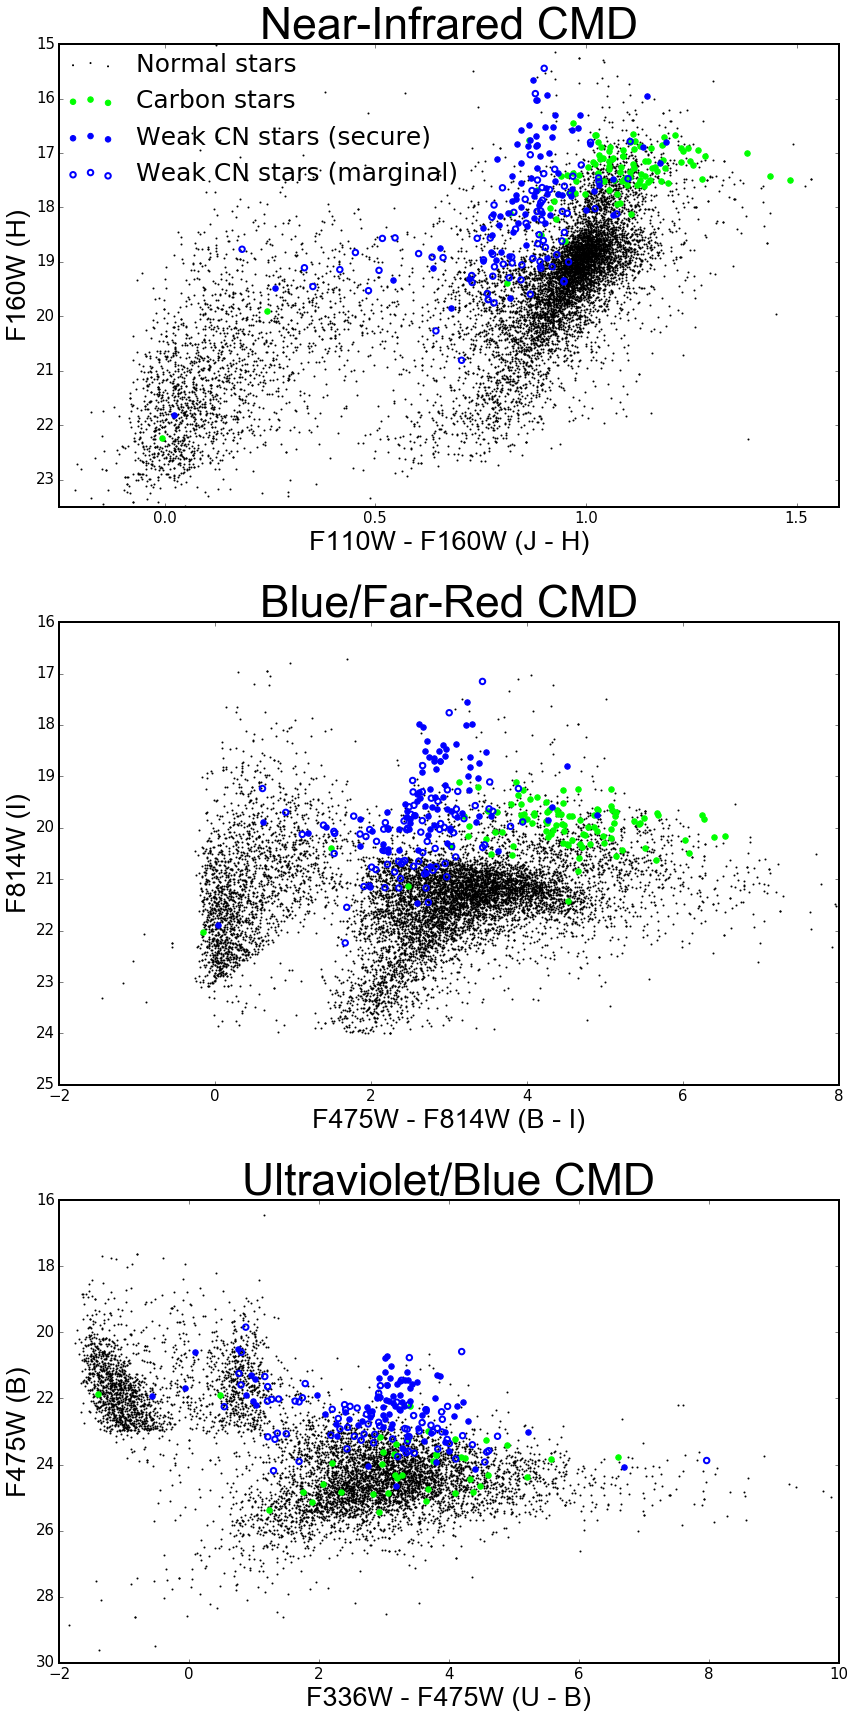

In [113]:
# subplot of three CMDs

py.rcParams['figure.figsize'] = 12,24
fig, axes = py.subplots(nrows=4, ncols=4)
py.subplot(3,1,1)

scalePlt = 1
scalePlt2 = 1.35


# NIR
py.rc('xtick', labelsize = 15) 
py.rc('ytick', labelsize = 15) 
py.rc('axes', linewidth = 2)
mm.cmd_plot4(ncData, range(len(ncData)), 1*scalePlt, 'k', label = 'Normal stars') #NONCARBON stars are BLACK and smaller
mm.cmd_plot4(Cdata, range(len(Cdata)), 30*scalePlt, 'lime', label = 'Carbon stars') #carbon stars are LIME
mm.cmd_plot4(wcData, range(len(wcData)), 30*scalePlt, 'b', label = 'Weak CN stars (secure)') #WEAK carbon stars are BLUE
py.scatter(marData.F110W[range(len(marData))] - marData.F160W[range(len(marData))], marData.F160W[range(len(marData))], s=30*scalePlt, linewidth = 2, edgecolors = 'b', facecolors = 'none', label = 'Weak CN stars (marginal)') #MARGINAL carbon stars are open blue 

py.xlim(-.25, 1.6)
py.ylim(23.5, 15)
py.title('Near-Infrared CMD', size = 33*scalePlt2, **font)
py.xlabel('F110W - F160W (J - H)', fontsize = 20*scalePlt2, **font)
py.ylabel('F160W (H)', fontsize = 20*scalePlt2, **font)
lg = py.legend(bbox_to_anchor=(.54, 1.03), fontsize = 25)
lg.get_frame().set_alpha(0)


py.subplot(3,1,2)
py.rc('xtick', labelsize = 15) 
py.rc('ytick', labelsize = 15) 
py.rc('axes', linewidth = 2)
mm.cmd_plot5(ncData, range(len(ncData)), 1*scalePlt, 'k', label = 'Normal stars') #NONCARBON stars are BLACK and smaller
mm.cmd_plot5(Cdata, range(len(Cdata)), 30*scalePlt, 'lime', label = 'Carbon stars') #carbon stars are LIME
mm.cmd_plot5(wcData, range(len(wcData)), 30*scalePlt, 'b', label = 'Weak CN stars (secure)') #WEAK carbon stars are BLUE
py.scatter(marData.F475W[range(len(marData))] - marData.F814W[range(len(marData))], marData.F814W[range(len(marData))], s=30*scalePlt, linewidth = 2, edgecolors = 'b', facecolors = 'none', label = 'Weak CN stars (marginal)') #MARGINAL carbon stars are open blue 

py.xlim(-2, 8)
py.ylim(25, 16)
py.title('Blue/Far-Red CMD', size = 33*scalePlt2, **font)
py.xlabel('F475W - F814W (B - I)', fontsize = 20*scalePlt2, **font)
py.ylabel('F814W (I)', fontsize = 20*scalePlt2, **font)



py.subplot(3,1,3)
py.rc('xtick', labelsize = 15) 
py.rc('ytick', labelsize = 15) 
py.rc('axes', linewidth = 2)
mm.cmd_plot6(ncData, range(len(ncData)), 1*scalePlt, 'k', label = 'Normal stars') #NONCARBON stars are BLACK and smaller
mm.cmd_plot6(Cdata, range(len(Cdata)), 30*scalePlt, 'lime', label = 'Carbon stars') #carbon stars are LIME
mm.cmd_plot6(wcData, range(len(wcData)), 30*scalePlt, 'b', label = 'Weak CN stars (secure)') #WEAK carbon stars are BLUE
py.scatter(marData.F336W[range(len(marData))] - marData.F475W[range(len(marData))], marData.F475W[range(len(marData))], s=30*scalePlt, linewidth = 2, edgecolors = 'b', facecolors = 'none', label = 'Weak CN stars (marginal)') #MARGINAL carbon stars are open blue 

py.xlim(-2, 10)
py.ylim(30, 16)
py.title('Ultraviolet/Blue CMD', size = 33*scalePlt2, **font)
py.xlabel('F336W - F475W (U - B)', fontsize = 20*scalePlt2, **font)
py.ylabel('F475W (B)', fontsize = 20*scalePlt2, **font)

fig.tight_layout(h_pad = 2.75)

In [114]:
# Track stuff...

trackSuffix = os.listdir('/Users/jonhays/Documents/ASTRO/Python notebooks/parsec_massive_phat')
trackSuffix

['Z0.02_Y0.284_M001.000.hb.phat.dat',
 'Z0.02_Y0.284_M001.000.phat.dat',
 'Z0.02_Y0.284_M002.000.phat.dat',
 'Z0.02_Y0.284_M003.000.phat.dat',
 'Z0.02_Y0.284_M004.000.phat.dat',
 'Z0.02_Y0.284_M005.000.phat.dat',
 'Z0.02_Y0.284_M006.000.phat.dat',
 'Z0.02_Y0.284_M007.000.phat.dat',
 'Z0.02_Y0.284_M008.000.phat.dat',
 'Z0.02_Y0.284_M009.000.phat.dat',
 'Z0.02_Y0.284_M010.000.phat.dat',
 'Z0.02_Y0.284_M011.000.phat.dat',
 'Z0.02_Y0.284_M012.000.phat.dat',
 'Z0.02_Y0.284_M014.000.phat.dat',
 'Z0.02_Y0.284_M016.000.phat.dat',
 'Z0.02_Y0.284_M018.000.phat.dat',
 'Z0.02_Y0.284_M020.000.phat.dat',
 'Z0.02_Y0.284_M024.000.phat.dat',
 'Z0.02_Y0.284_M028.000.phat.dat',
 'Z0.02_Y0.284_M030.000.phat.dat',
 'Z0.02_Y0.284_M035.000.phat.dat',
 'Z0.02_Y0.284_M040.000.phat.dat',
 'Z0.02_Y0.284_M050.000.phat.dat',
 'Z0.02_Y0.284_M055.000.phat.dat',
 'Z0.02_Y0.284_M060.000.phat.dat',
 'Z0.02_Y0.284_M065.000.phat.dat',
 'Z0.02_Y0.284_M070.000.phat.dat',
 'Z0.02_Y0.284_M080.000.phat.dat',
 'Z0.02_Y0.284_M0

In [116]:
# massStrArray = []
# for i in range(len(trackSuffix)):
    

In [117]:
def getTrackDataMatrix(path):
    with open('/Users/jonhays/Documents/ASTRO/Python notebooks/parsec_massive_phat/' + path) as file:
        x = []
        for line in file:
            lineArray = line.split()
            x += [lineArray]
    return x

In [118]:
def plotRegTrack(i, x1, y):
    matrix = getTrackDataMatrix(i)
    xArray = []
    yArray = []
    for p in range(1,len(matrix)):
        if float(matrix[p][23]) >= 5:
            xArray.append(float(matrix[p][x1]) - float(matrix[p][y]))
            yArray.append(float(matrix[p][y]) + 24.469)
    massStr = str(i[15]) + str(i[16])
    py.plot(xArray, yArray, label = massStr + r'$M_{\odot}$', linewidth = 1.5)

In [119]:
def plotTrackIHH(i):
    matrix = getTrackDataMatrix(i)
    xArray = []
    yArray = []
    for p in range(1,len(matrix)):
        xArray.append((float(matrix[p][28]) + 24.47) - (float(matrix[p][30]) + 24.47))
        yArray.append((float(matrix[p][30]) + 24.47))
    py.plot(xArray, yArray, linewidth = 2)

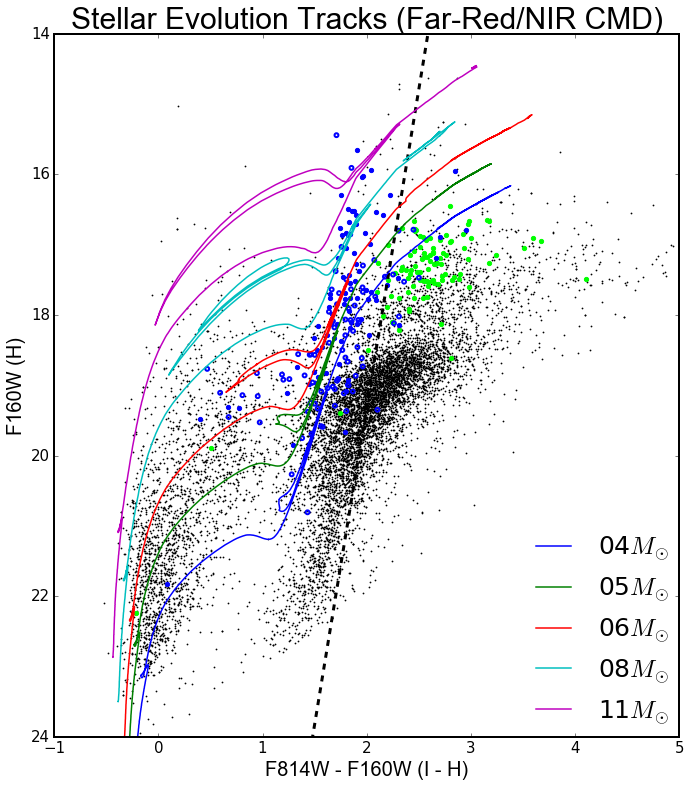

In [120]:
# H vs. I - H CMD for poster

usedTrackSuffix = []
usedTrackSuffix += trackSuffix[4], trackSuffix[5], trackSuffix[6], trackSuffix[8], trackSuffix[11]

py.rcParams['figure.figsize'] = 16*.7,18*.7
py.rc('xtick', labelsize = 15) 
py.rc('ytick', labelsize = 15) 
py.rc('axes', linewidth = 2)
mm.cmd_plot2(ncData, range(len(ncData)), 1*.6, 'k') #NONCARBON stars are BLACK and smaller
mm.cmd_plot2(Cdata, range(len(Cdata)), 30*.6, 'lime') #carbon stars are LIME
mm.cmd_plot2(wcData, range(len(wcData)), 30*.6, 'b') #WEAK carbon stars are BLUE
py.scatter(marData.F814W[range(len(marData))] - marData.F160W[range(len(marData))], marData.F160W[range(len(marData))], s=30*.5, linewidth = 2, edgecolors = 'b', facecolors = 'none') #MARGINAL carbon stars are open blue 

py.plot(xPhil, yPhil, color = 'k', linewidth = 3, linestyle = '--')


py.xlabel('F814W - F160W (I - H)')
py.ylabel('F160W (H)')
for i in usedTrackSuffix:
    plotRegTrack(i, 28, 30)
    

# bin1 = py.Polygon([[3.2, 19.], [3.50, 16.5], [4.999, 17], [4.9, 18.2]], color = 'brown', fill = False, linewidth = 2)
# bin1path = Path([[3.2, 19.], [3.50, 16.5], [4.999, 17], [4.9, 18.2]])
# py.gca().add_patch(bin1)

# bin2 = py.Polygon([[2.99, 16.5], [2.685, 19.2], [3.2, 19.], [3.50, 16.5]], color = 'red', fill = False, linewidth = 2)
# bin2path = Path([[2.99, 16.5], [2.685, 19.2], [3.2, 19.], [3.50, 16.5]])
# py.gca().add_patch(bin2)
# # mask = bin5.contains_point([1,0])

# bin3 = py.Polygon([[2.814, 15], [3.1506, 15], [2.785, 18.3], [2.442, 18.3]], color = 'darkorange', fill = False, linewidth = 2)
# bin3path = Path([[2.814, 15], [3.1506, 15], [2.785, 18.3], [2.442, 18.3]])
# py.gca().add_patch(bin3)

# bin4 = py.Polygon([[2.442, 18.3], [2.785, 18.3], [2.685, 19.2], [2.31, 19.5]], color = 'gold', fill = False, linewidth = 2)
# bin4path = Path([[2.442, 18.3], [2.785, 18.3], [2.685, 19.2], [2.31, 19.5]])
# py.gca().add_patch(bin4)

# bin5 = py.Polygon([[2.477468, 15], [2.814, 15], [2.442, 18.3], [2.079, 18.6]], color = 'green', fill = False, linewidth = 2)
# bin5path = Path([[2.477468, 15], [2.814, 15], [2.442, 18.3], [2.079, 18.6]])
# py.gca().add_patch(bin5)

# bin6 = py.Polygon([[2.079, 18.6], [2.442, 18.3], [2.31, 19.5], [1.8795, 20.4]], color = 'blue', fill = False, linewidth = 2)
# bin6path = Path([[2.079, 18.6], [2.442, 18.3], [2.31, 19.5], [1.8795, 20.4]])
# py.gca().add_patch(bin6)

# bin7 = py.Polygon([[1.4,19.15],[2.079, 18.6],[2.4996,14.8],[1.82,15.5]], color = 'indigo', fill = False, linewidth = 2)
# bin7path = Path([[1.4,19.15],[2.079, 18.6],[2.4996,14.8],[1.82,15.5]])
# py.gca().add_patch(bin7)

# bin8 = py.Polygon([[1.4,19.15],[2.079, 18.6],[1.985, 19.45],[1.387,19.45]], color = 'darkviolet', fill = False, linewidth = 2)
# bin8path = Path([[1.4,19.15],[2.079, 18.6],[1.985, 19.45],[1.387,19.45]])
# py.gca().add_patch(bin8)

# bin9 = py.Polygon([[1.387,19.45],[1.985, 19.45],[1.8795, 20.4],[1.333, 20.4]], color = 'magenta', fill = False, linewidth = 2)
# bin9path = Path([[1.387,19.45],[1.985, 19.45],[1.8795, 20.4],[1.333, 20.4]])
# py.gca().add_patch(bin9)

# bin10 = py.Polygon([[1.333, 20.4],[1.8795, 20.4],[1.75,21.5],[1.268,21.5]], color = 'hotpink', fill = False, linewidth = 2)
# bin10path = Path([[1.333, 20.4],[1.8795, 20.4],[1.75,21.5],[1.268,21.5]])
# py.gca().add_patch(bin10)

# bin11 = py.Polygon([[1.268,21.5],[1.75,21.5],[1.6524,22.45],[1.2,22.8]], color = 'violet', fill = False, linewidth = 2)
# bin11path = Path([[1.268,21.5],[1.75,21.5],[1.6524,22.45],[1.2,22.8]])
# py.gca().add_patch(bin11)


# py.text(4, 18, '1', color = 'brown', fontsize = 40, **font)
# py.text(3, 18.2, '2', color = 'red', fontsize = 40, **font)
# py.text(2.85, 15.5, '3', color = 'orange', fontsize = 40, **font)
# py.text(2.5, 15.5, '5', color = 'green', fontsize = 40, **font)
# py.text(2.15, 15.7, '7', color = 'indigo', fontsize = 40, **font)

# py.annotate('4', (2.55, 19.35), xytext=(2.7,20.33), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'gold', fontsize = 40, **font)
# py.annotate('6', (2.15, 19.9), xytext=(2.2,20.7), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'blue', fontsize = 40, **font)
# py.annotate('8', (1.4, 19.3), xytext=(.75, 20), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'darkviolet', fontsize = 40, **font)
# py.annotate('9', (1.35, 19.95), xytext=(.75, 20.7), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'magenta', fontsize = 40, **font)
# py.annotate('10', (1.3, 21), xytext=(.65, 21.4), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'hotpink', fontsize = 40, **font)
# py.annotate('11', (1.2, 22), xytext=(.65, 22.1), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'violet', fontsize = 40, **font)
# py.annotate('RHeB-AGB Separation Line', (2.6, 14.2), xytext=(2.75, 14.8), arrowprops = {'shrink' : 0.05, 'facecolor' : 'black', 'alpha': 0.7, 'linewidth': .1}, color = 'black', fontsize = 21, **font)


# # refPoint= py.scatter(2, 18.5, s=100, color = 'magenta')
# # refPoint2= py.scatter(2.8455, 17.75, s=100, color = 'orange')


py.xlim(-1, 5)
py.ylim(24, 14)
py.title('Stellar Evolution Tracks (Far-Red/NIR CMD)', size = 30, **font)
py.xlabel('F814W - F160W (I - H)', fontsize = 20, **font)
py.ylabel('F160W (H)', fontsize = 20, **font)
lg = py.legend(bbox_to_anchor=(1.02, .32), fontsize = 25)
lg.get_frame().set_alpha(0)

# tracks for M = (3, 5, 7, 9) solar masses

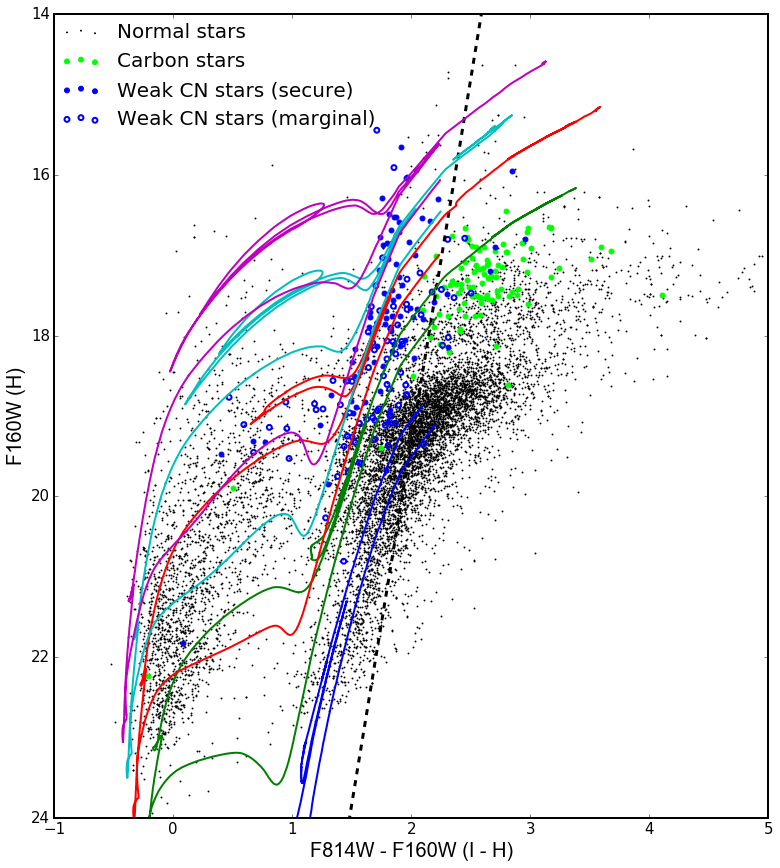

In [122]:
# H vs. I - H CMD for poster

py.rcParams['figure.figsize'] = 16*.8,18*.8
py.rc('xtick', labelsize = 15) 
py.rc('ytick', labelsize = 15) 
py.rc('axes', linewidth = 2)
mm.cmd_plot2(ncData, range(len(ncData)), 1*.8, 'k', label = 'Normal stars') #NONCARBON stars are BLACK and smaller
mm.cmd_plot2(Cdata, range(len(Cdata)), 30*.8, 'lime', label = 'Carbon stars') #carbon stars are LIME
mm.cmd_plot2(wcData, range(len(wcData)), 30*.8, 'b', label = 'Weak CN stars (secure)') #WEAK carbon stars are BLUE
py.scatter(marData.F814W[range(len(marData))] - marData.F160W[range(len(marData))], marData.F160W[range(len(marData))], s=30*.8, linewidth = 2, edgecolors = 'b', facecolors = 'none', label = 'Weak CN stars (marginal)') #MARGINAL carbon stars are open blue 

py.plot(xPhil, yPhil, color = 'k', linewidth = 3, linestyle = '--')


py.xlabel('F814W - F160W (I - H)')
py.ylabel('F160W (H)')
for i in trackSuffix[2:11:2]:
    plotTrackIHH(i)

# plotTrackIHH(trackSuffix[6])

py.xlim(-1, 5)
py.ylim(24, 14)
# py.title('A Particularly Insightful Far-Red/Near-Infrared CMD...', size = 30, **font)
py.xlabel('F814W - F160W (I - H)', fontsize = 20, **font)
py.ylabel('F160W (H)', fontsize = 20, **font)
lg = py.legend(bbox_to_anchor=(.475, 1.012), fontsize = 20)
lg.get_frame().set_alpha(0)

# tracks for M = (2, 4, 6, 8, 10) solar masses

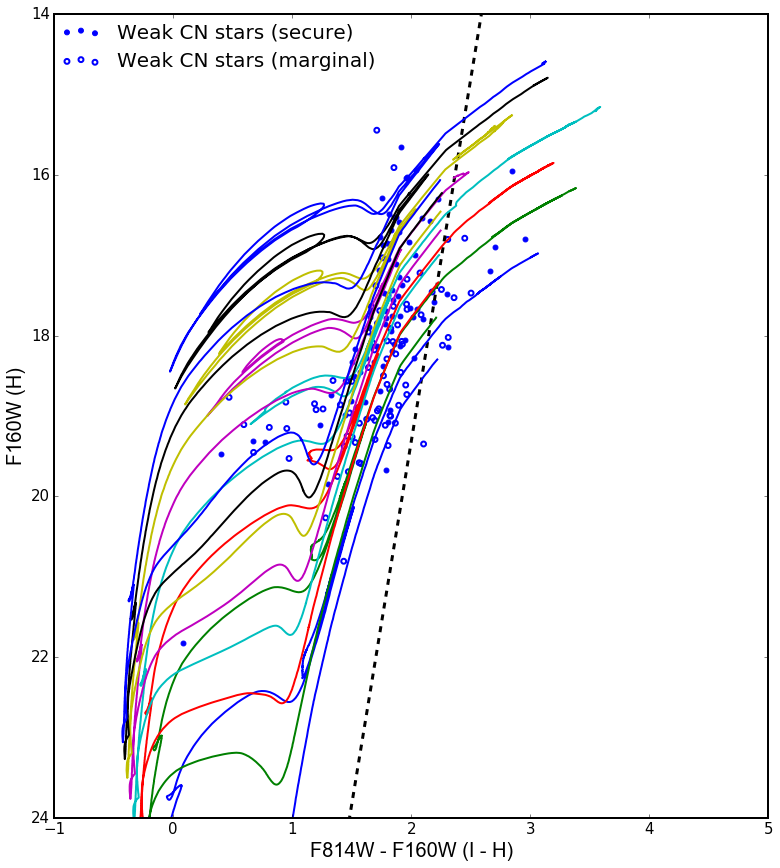

In [123]:
# H vs. I - H CMD for poster

py.rcParams['figure.figsize'] = 16*.8,18*.8
py.rc('xtick', labelsize = 15) 
py.rc('ytick', labelsize = 15) 
py.rc('axes', linewidth = 2)
# mm.cmd_plot2(ncData, range(len(ncData)), 1*.8, 'k', label = 'Normal stars') #NONCARBON stars are BLACK and smaller
# mm.cmd_plot2(Cdata, range(len(Cdata)), 30*.8, 'lime', label = 'Carbon stars') #carbon stars are LIME
mm.cmd_plot2(wcData, range(len(wcData)), 30*.8, 'b', label = 'Weak CN stars (secure)') #WEAK carbon stars are BLUE
py.scatter(marData.F814W[range(len(marData))] - marData.F160W[range(len(marData))], marData.F160W[range(len(marData))], s=30*.8, linewidth = 2, edgecolors = 'b', facecolors = 'none', label = 'Weak CN stars (marginal)') #MARGINAL carbon stars are open blue 

py.plot(xPhil, yPhil, color = 'k', linewidth = 3, linestyle = '--')


py.xlabel('F814W - F160W (I - H)')
py.ylabel('F160W (H)')
for i in trackSuffix[3:11]:
    plotTrackIHH(i)

py.xlim(-1, 5)
py.ylim(24, 14)
# py.title('A Particularly Insightful Far-Red/Near-Infrared CMD...', size = 30, **font)
py.xlabel('F814W - F160W (I - H)', fontsize = 20, **font)
py.ylabel('F160W (H)', fontsize = 20, **font)
lg = py.legend(bbox_to_anchor=(.475, 1.012), fontsize = 20)
lg.get_frame().set_alpha(0)

# tracks for M = (3–10) solar masses